In [57]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, glob, re
import sklearn
%matplotlib inline  

In [58]:
def percent_reconstruct(eig_vals, ncomp):
    abs_eig = np.fabs(eig_vals)
    norm = np.sum(abs_eig)
    percent = abs_eig / norm
    return np.sum(percent[:ncomp])

# Get Data

In [59]:
snid_dir = './allSNIDtemp/'
os.chdir('./allSNIDtemp/')
all_spec = glob.glob('*.lnw')
os.chdir('..')

In [60]:
# Get List of spectra files that are type Ib or Ic

# For some reason, these files do not have a standard organization, which makes it
# stupidly aggravating to load them all. Here we search for spectra of type Ib or Ic
# and find the line number where the wavelength 2501.69 appears (this is the first).
Ib_Ic = []
Ib_Ic_names = []
skiprows = []
SN_type_vec = []
phase_type = []
phases = []
for spec_name in all_spec:
    path = snid_dir + spec_name
    with open(path, 'r') as f:
        lines = f.readlines()
        header = lines[0].split()
        SN_type = int(header[-2])
        SN_sub_type = int(header[-1])
        if ((SN_type == 2) or (SN_type == 3)):
            
            Ib_Ic.append(path)
            Ib_Ic_names.append(spec_name[:-4])
            type_tup = [SN_type, SN_sub_type]
            SN_type_vec.append(type_tup)
            #the first observed wavelength is always 2501.69
            first_wvl = '2501.69'
            for i in range(len(lines)-1):
                line = lines[i]
                if first_wvl in line:
                    skiprows.append(i)
                    phase_row = lines[i-1].split()
                    phase_type.append(int(phase_row[0]))
                    phases.append([float(ph) for ph in phase_row[1:]])
                    break
                    
phase_type = np.array(phase_type)
phases = [np.array(ph) for ph in phases]
SN_type_vec = np.array(SN_type_vec)
Ib_Ic_names = np.array(Ib_Ic_names)

In [61]:
# phase value is the phase, using the definition where phase is number
# of days after max light. This code finds the observed phase closest to 
# the chose phase_value.

phase_value = 15
phase_cols = []
phase_arr = []
for i in range(len(phase_type)):
    idx = (np.abs(phases[i] - phase_value)).argmin()
    phase_cols.append(idx)
    phase_arr.append(phases[i][idx])
print phase_cols
phase_arr = np.array(phase_arr)
#phase_arr[3]=1
#print phase_arr[3]

[6, 14, 7, 0, 0, 0, 4, 4, 7, 1, 6, 2, 0, 5, 0, 0, 0, 4, 0, 6, 5, 0, 1, 4, 7, 2, 0, 0, 0, 20, 9, 4, 6, 1, 14, 0, 1, 5, 0, 5, 7, 5, 12, 0, 2, 0, 7, 24, 4, 7, 0, 1, 15, 8, 4, 0, 22, 0, 12, 0, 7, 2, 0, 2, 2, 0, 11, 0, 3, 0, 2, 5, 13, 0, 3, 1, 23, 14, 7, 0, 0, 13, 0, 4, 0, 0, 1, 3, 7, 1, 0, 3, 19, 16, 0, 3, 2, 5, 4, 2, 2, 2, 0, 0, 5, 0, 0, 7, 0, 7, 1, 4, 1, 14, 1, 0, 0, 2, 0, 1, 7, 1, 2, 3, 2, 8, 1, 5, 1, 0, 5, 1, 0, 6, 16, 4, 2, 0, 0, 3, 0, 23, 0, 0, 19, 1, 4, 5, 0, 10, 0, 0, 0]


(array([  2.,   4.,   3.,   5.,  12.,  28.,  26.,   3.,   0.,   1.]),
 array([ -8.11 ,  -4.199,  -0.288,   3.623,   7.534,  11.445,  15.356,
         19.267,  23.178,  27.089,  31.   ]),
 <a list of 10 Patch objects>)

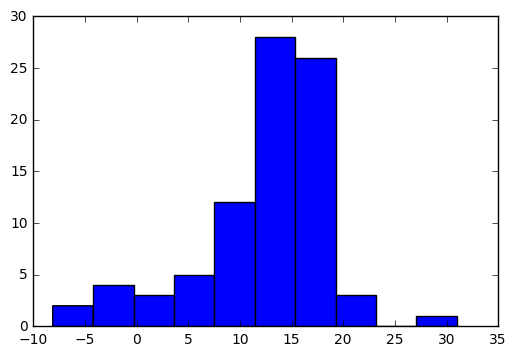

In [62]:
plt.hist(phase_arr[phase_type==0][phase_arr[phase_type==0]>-500])


In [63]:
print "There are %d type Ib and Ic SN"%(len(Ib_Ic))

There are 153 type Ib and Ic SN


In [64]:
# For each spectra, skip all the header lines about removing continuum and load the phase=0
# spectra into a numpy array. Do some data processing like filtering for desired wavelengths and 
# normalizing data.

min_wavelength = 4000
max_wavelength = 7000

spectra = []
for i in range(len(Ib_Ic)):
    spec = Ib_Ic[i]
    skiprow = skiprows[i]
    s = np.loadtxt(spec,skiprows=skiprow, usecols=(0,phase_cols[i]+1)) # Note the +1 because in the SNID files there is a 0/1 phase type
    
    # check that first wvl is 2501.69
    if not(s[0][0] == 2501.69): print 'first wavelength is not 2501.69'
    
    # filter for desired wavelengths
    mask = np.logical_and(s[:,0]>min_wavelength, s[:,0]<max_wavelength)
    s = s[mask]
    spectra.append(s)
    
SN_type_vec = np.array(SN_type_vec)

In [65]:
# Organize spectra in an (N x M) array, where N is the number of spectra, and M is the dimensionality
# (ie number of data points in spectrum) of a spectrum. We treat each wavelength as independent
# and zero the means and unify the standard deviations.

wavelengths = np.array(spectra[0][:,0])
spectra_matrix = np.ndarray((len(spectra),spectra[0].shape[0]))
for i, spec in enumerate(spectra):
    spectra_matrix[i,:] = spec[:,1]
    
#spectra_mean = np.mean(spectra_matrix, axis=1)
#spectra_std = np.std(spectra_matrix, axis=1)



In [66]:
phase_range = np.logical_and(phase_arr>10, phase_arr<20)
phase_mask = np.logical_and(phase_type==0, phase_range)
#phase_mask = phase_type==0
print len(phase_mask)
print spectra_matrix.shape
spectra_matrix[phase_mask].shape
spectra_matrix = spectra_matrix[phase_mask]
SN_type_vec = SN_type_vec[phase_mask]
phase_arr = phase_arr[phase_mask]
Ib_Ic_names = Ib_Ic_names[phase_mask]
print SN_type_vec.shape
print spectra_matrix.shape
print Ib_Ic_names.shape

153
(153, 414)
(59, 2)
(59, 414)
(59,)


(array([  4.,   5.,   8.,   4.,   8.,   8.,  10.,   7.,   1.,   4.]),
 array([ 10.4 ,  11.24,  12.08,  12.92,  13.76,  14.6 ,  15.44,  16.28,
         17.12,  17.96,  18.8 ]),
 <a list of 10 Patch objects>)

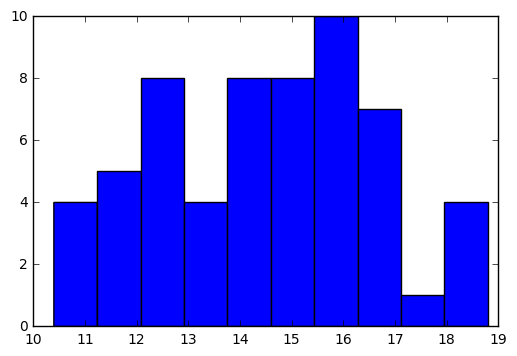

In [67]:
plt.hist(phase_arr)

In [68]:
# replace 0 values with NaN's

for i in range(spectra_matrix.shape[0]):
    spectra_matrix[i][spectra_matrix[i]==0] = np.nan

In [69]:
spectra_mean = np.nanmean(spectra_matrix, axis=1)
spectra_std = np.nanstd(spectra_matrix, axis=1)
original_spectra = np.copy(spectra_matrix)
spectra_matrixT = (spectra_matrix.T - spectra_mean)/spectra_std
spectra_matrix = spectra_matrixT.T

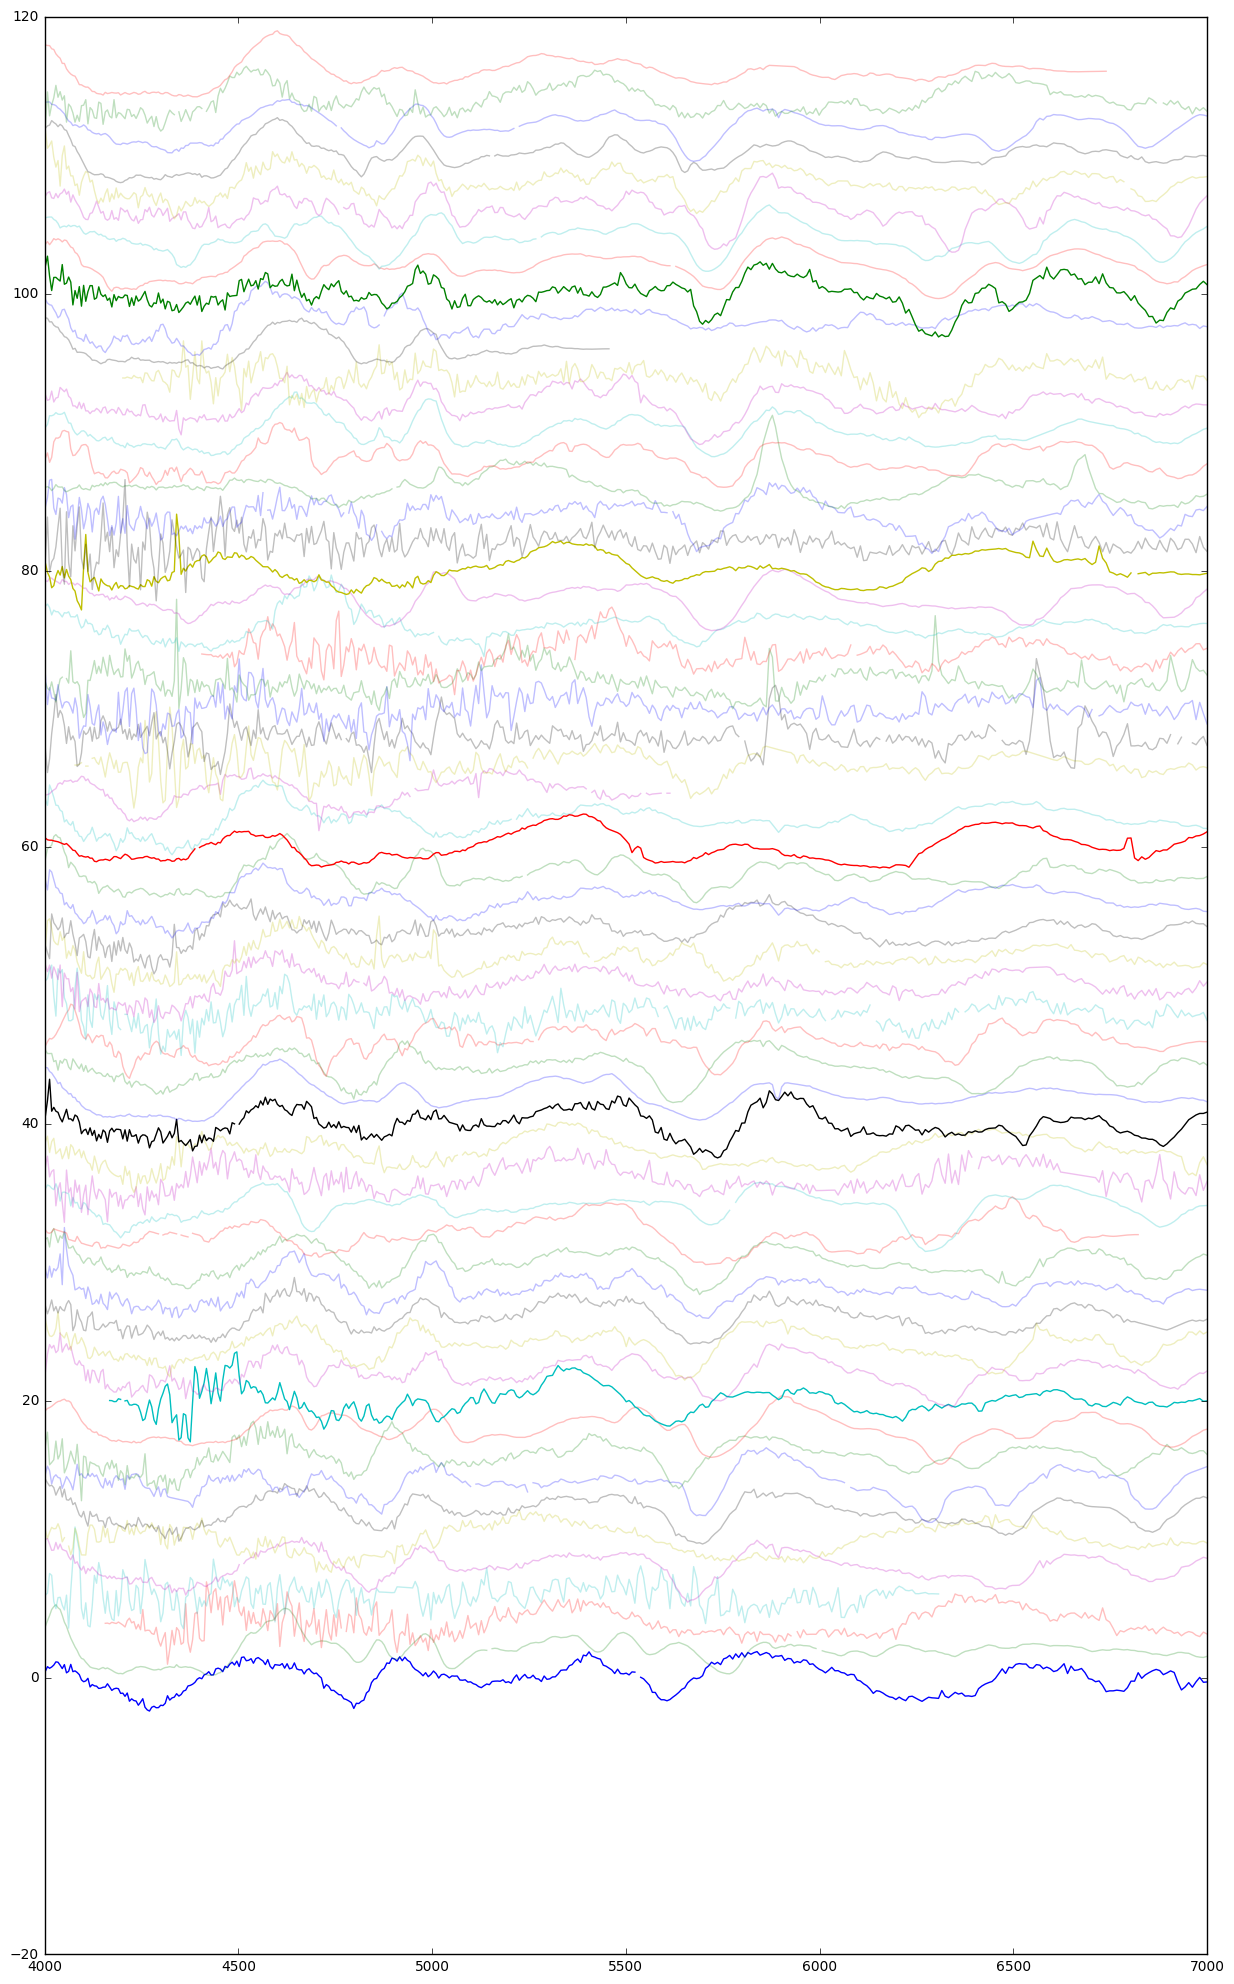

In [70]:
plt.figure(figsize=(15,25))
for i,spec in enumerate(spectra_matrix):
    alpha=0.25
    if not i%10:
        alpha=1
    plt.plot(wavelengths,spec+i*2, alpha=alpha)

# Data Cleaning

## Test spectrum interpolation

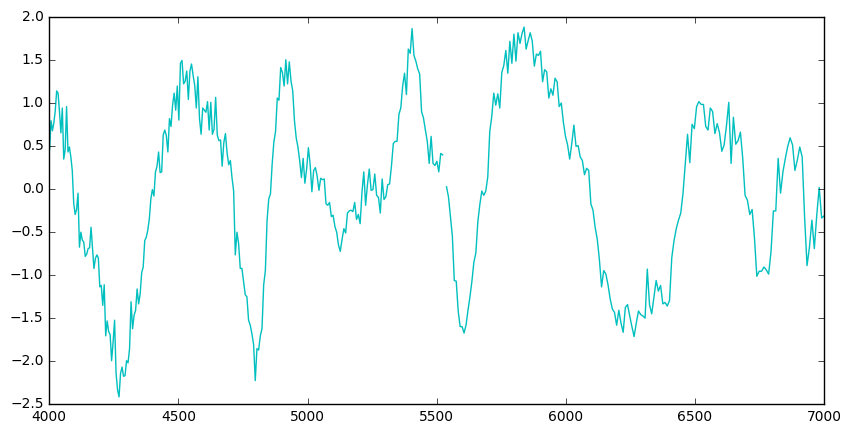

In [71]:
test_spec = spectra_matrix[0]
plt.figure(figsize=(10,5))
plt.plot(wavelengths,test_spec,'c')

In [72]:
from scipy.interpolate import interp1d

In [73]:
good_values = np.isfinite(test_spec)
interp_fn = interp1d(wavelengths[good_values],test_spec[good_values])

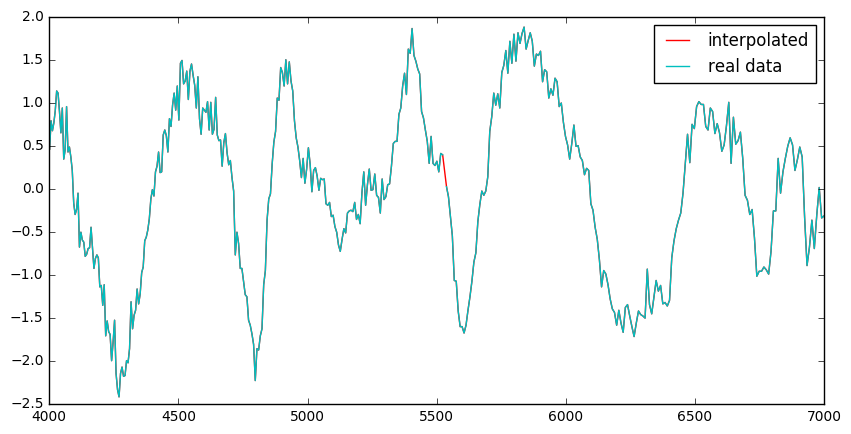

In [74]:
plt.figure(figsize=(10,5))
p1 = plt.plot(wavelengths,interp_fn(wavelengths),'r',label="interpolated")
p2 = plt.plot(wavelengths,test_spec,'c',label="real data")
plt.legend()

## Re-bin (lower resolution b/c don't care about noise)

In [75]:
print spectra_matrix.shape
print wavelengths.shape

(59, 414)
(414,)


In [76]:
nrows, ncols = spectra_matrix.shape
smoothing = 2 # Width of bins in terms of number of wavelength steps
tmp = np.reshape(spectra_matrix,(nrows, ncols/smoothing, smoothing))

In [77]:
spectra_matrix = np.nanmean(tmp, axis=2)

In [78]:
spectra_matrix.shape

(59, 207)

In [79]:
wvrows = wavelengths.shape[0]
wvcols = 1
wvtemp = np.reshape(wavelengths, (wvrows/smoothing,1,smoothing))
print wvtemp.shape
wavelengths = np.nanmean(wvtemp, axis=2)

(207, 1, 2)


In [80]:
wavelengths.shape

(207, 1)

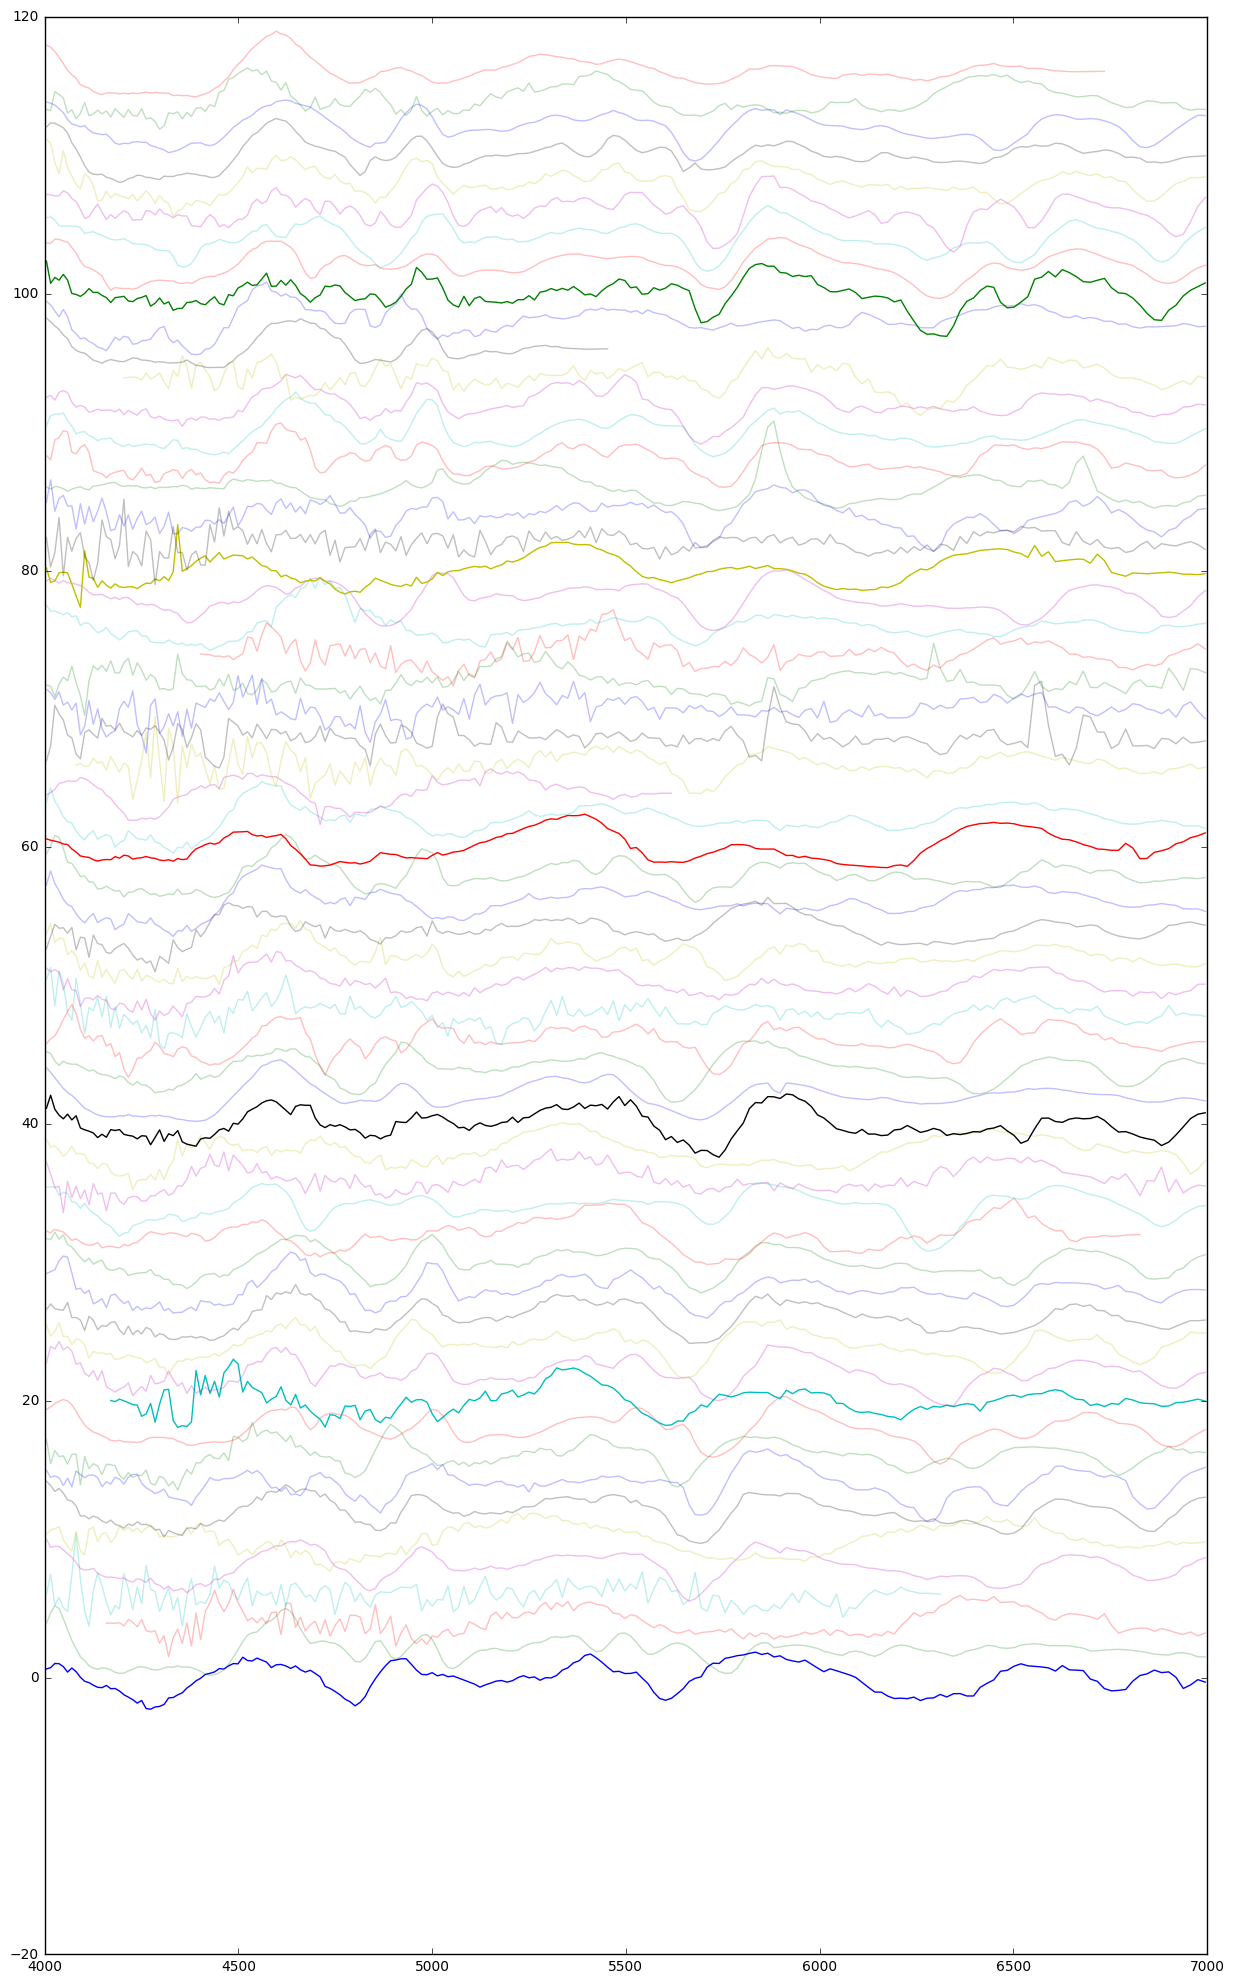

In [81]:
# Plot the spectra post data processing

plt.figure(figsize=(15,25))
for i,spec in enumerate(spectra_matrix):
    alpha=0.25
    if not i%10:
        alpha=1
    plt.plot(wavelengths,spec+i*2, alpha=alpha)

In [82]:
big_gap_mask = np.array([np.isnan(spec).any() for spec in spectra_matrix])
print 'total number of bad spectra = %d'%(np.sum(big_gap_mask))

total number of bad spectra = 10


In [83]:
spectra_matrix = spectra_matrix[np.invert(big_gap_mask)]
SN_type_vec = SN_type_vec[np.invert(big_gap_mask)]
Ib_Ic_names = Ib_Ic_names[np.invert(big_gap_mask)]

In [84]:
print spectra_matrix.shape
print SN_type_vec.shape
print Ib_Ic_names.shape

(49, 207)
(49, 2)
(49,)


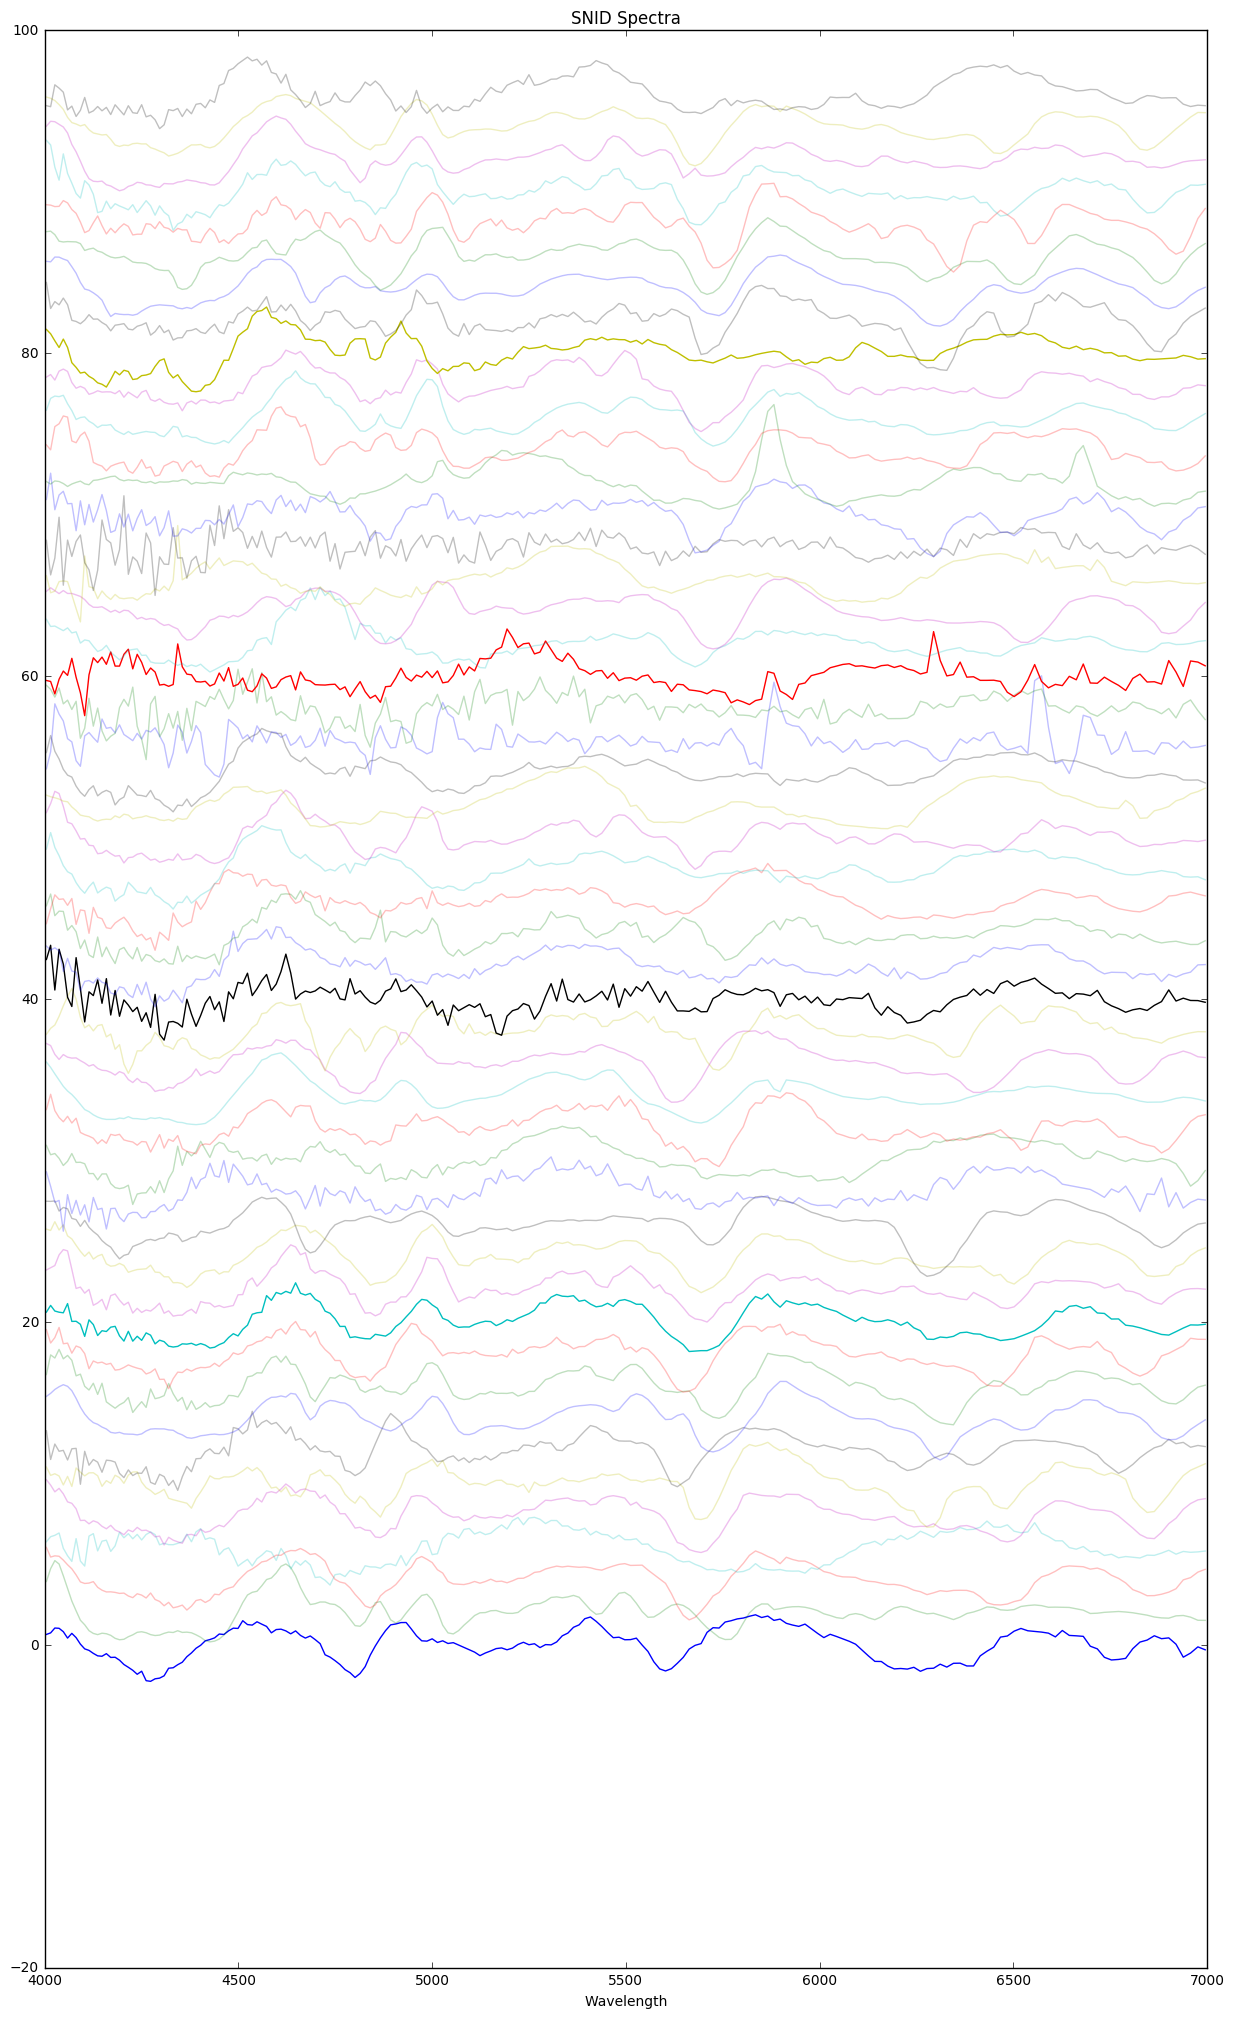

In [85]:
plt.figure(figsize=(15,25))
for i,spec in enumerate(spectra_matrix):
    alpha=0.25
    if not i%10:
        alpha=1
    plt.plot(wavelengths,spec+i*2, alpha=alpha)
    
plt.title('SNID Spectra')
plt.xlabel('Wavelength')
#plt.savefig('plots/All_spec_post_process_phase15pm5.png')

## PCA Decomposition

In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer


#imp = Imputer(missing_values='NaN', strategy='mean', axis=1, verbose=0, copy=True)


In [87]:
#spectra_matrix = imp.fit_transform(spectra_matrix)

In [88]:
spectra_matrix.shape

(49, 207)

In [89]:
spectra_matrix

array([[ 0.62930825,  0.72409766,  1.02495099, ..., -0.52464973,
        -0.14137083, -0.32270709],
       [ 1.90843201,  2.70317511,  3.20039899, ..., -0.30054624,
        -0.4941375 , -0.50025091],
       [ 2.0173673 ,  1.42111862,  1.49625565, ...,  0.14863669,
         0.4879652 ,  0.66247701],
       ..., 
       [ 2.04228466,  2.34698526,  2.31969864, ..., -0.09971509,
        -0.07242847, -0.03604631],
       [ 1.84725525,  1.7697524 ,  1.63024726, ...,  0.60720959,
         0.89286297,  0.87957677],
       [-0.68702565, -0.74993009,  0.60601004, ..., -0.73944602,
        -0.65557343, -0.68702565]])

In [90]:
pca = PCA()

In [91]:
pca.fit(spectra_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [92]:
pca.components_

array([[-0.06585487, -0.09261619, -0.08220464, ..., -0.01753717,
        -0.03406281, -0.04689867],
       [-0.07486536, -0.09026583, -0.067392  , ...,  0.02110574,
         0.03851631,  0.05017289],
       [-0.01020957, -0.07726505, -0.05753052, ...,  0.08447767,
         0.07229636,  0.05126563],
       ..., 
       [-0.00907956, -0.08752742, -0.11057251, ...,  0.02760203,
         0.0650043 ,  0.11418852],
       [ 0.07524837, -0.13848571,  0.0919643 , ..., -0.0460916 ,
         0.00827705, -0.0320545 ],
       [ 0.1119772 , -0.04948357, -0.16699021, ...,  0.00128165,
         0.00608689,  0.00186927]])

In [93]:
evecs = pca.components_
evals = pca.explained_variance_ratio_
evals_cs = evals.cumsum()

n_evecs = evecs.shape[0]
n_feat = evecs.shape[1]

In [94]:
print evecs.shape
print evals.shape

(49, 207)
(49,)


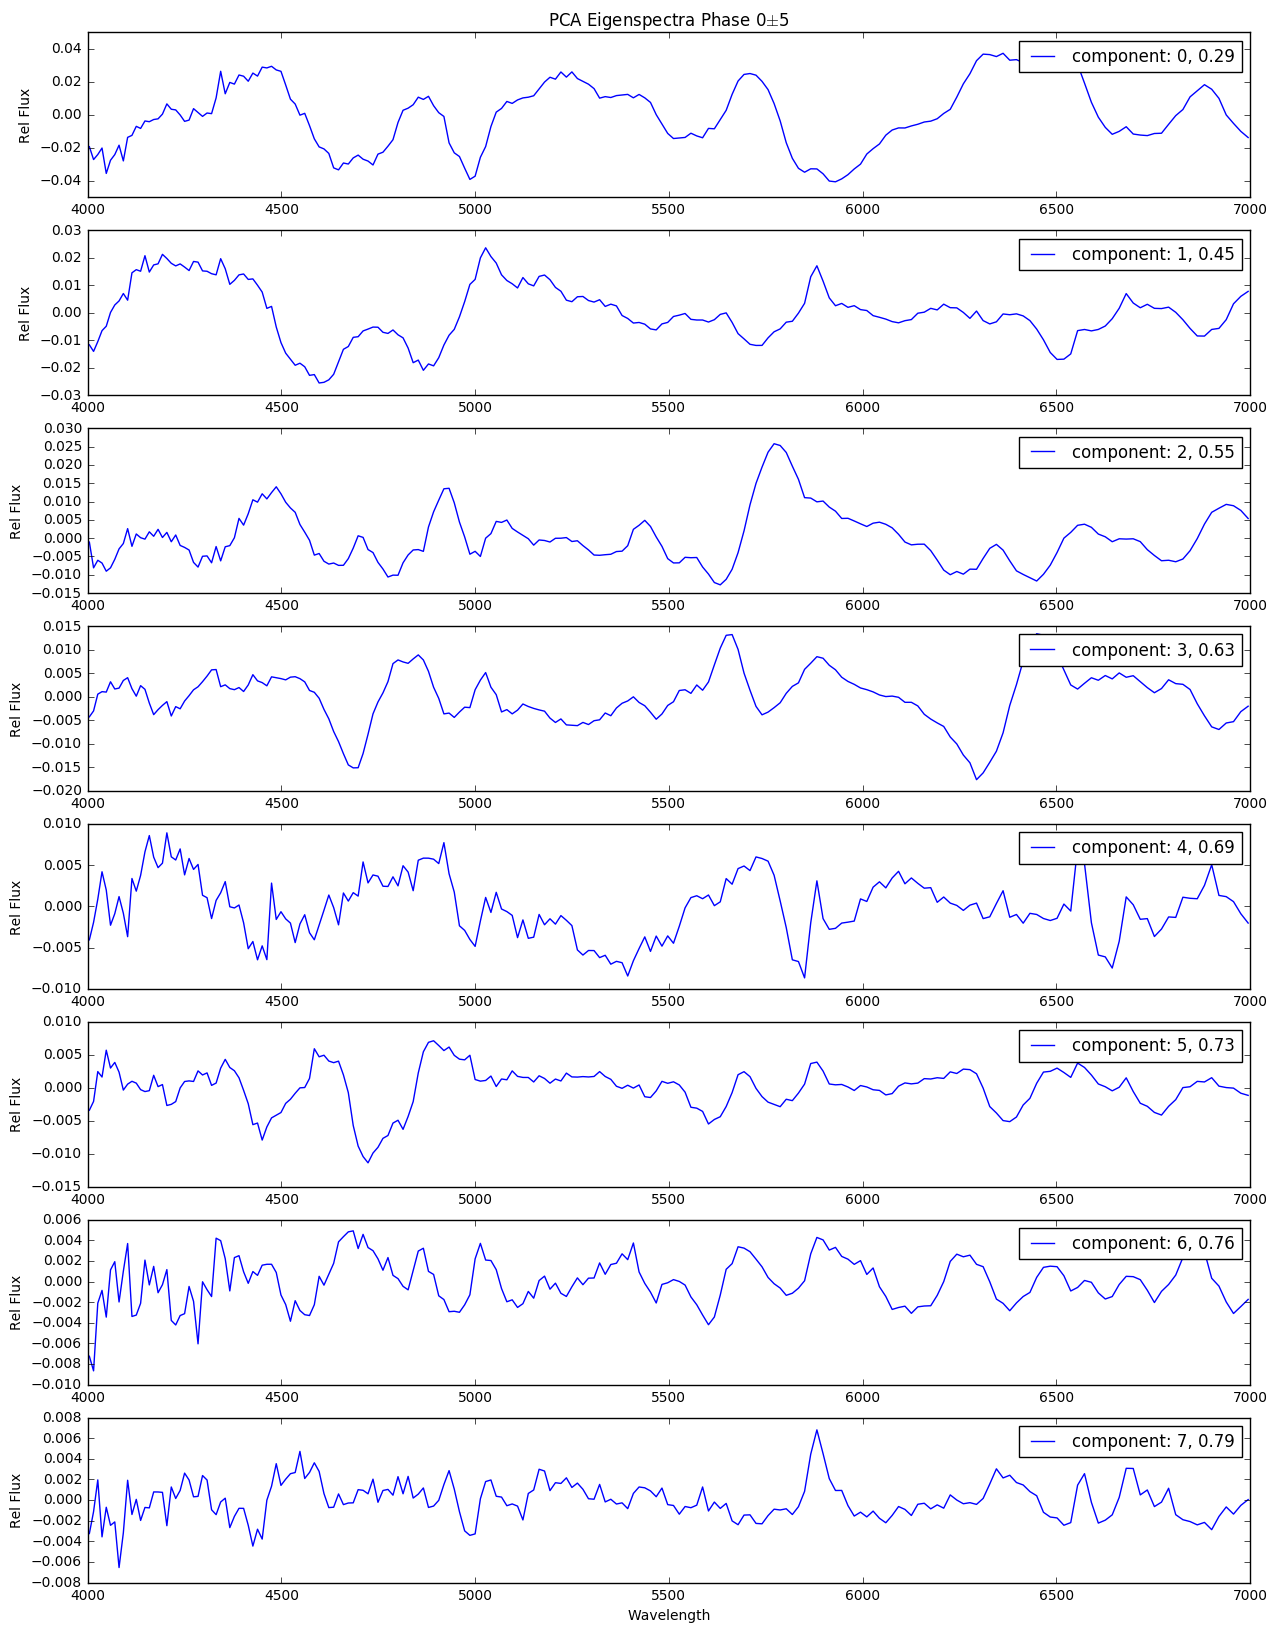

In [95]:
f = plt.figure(figsize=(15,20))
nshow=8
for i,ev in enumerate(evecs[:nshow]):
    #plt.figure(figsize=(15,2))
    plt.subplot(nshow,1,i+1)
    plt.plot(wavelengths,evals[i]*(ev), label="component: %d, %.2f"%(i,evals_cs[i]))
    if i==0:
        plt.title('PCA Eigenspectra Phase 0$\pm$5')
    if i==nshow-1:
        plt.xlabel('Wavelength')
    plt.ylabel('Rel Flux')
    plt.legend(fontsize=12)
    
    
#plt.savefig("plots/PCA_eigenspectra_phase0pm5.png")
#np.save('eigen_spec_phase15pm5.npy',evecs[:8])
#np.save('wavelengths_phase15pm5.npy',wavelengths)

## Recreate Spectra from PCA

[7]
[0, 4, 8, 20, 49]
(49, 207)
(207,)


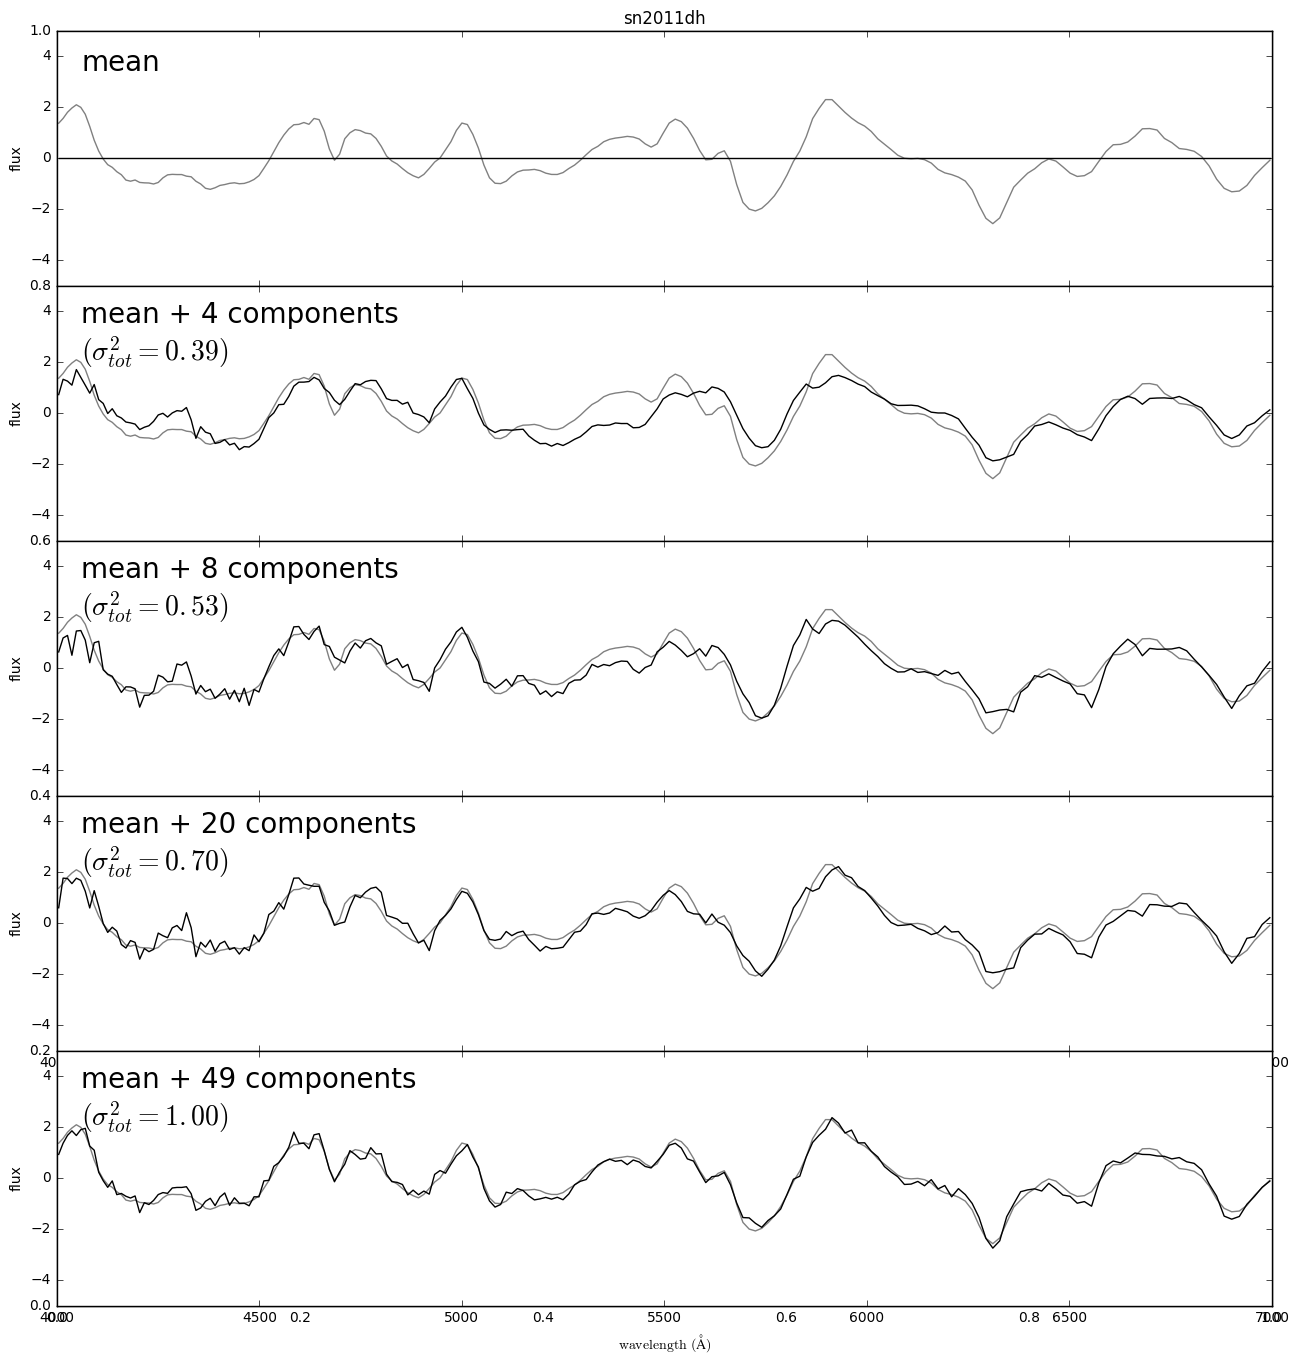

In [232]:
# Recreate 10 random spectra using the PCA decomposition
random_spec = np.random.randint(0,spectra_matrix.shape[0],1)
print random_spec
n_pca_components = [0,4,8,20,n_evecs]
print n_pca_components

for j,spec in enumerate(random_spec):
    spec_name = Ib_Ic_names[spec]
    true_spec = spectra_matrix[spec]
    
    print evecs.shape
    print spectra_matrix[spec].shape
    pca_coeff = np.dot(evecs, spectra_matrix[spec])
    
    
    #------------------------------------------------------------
    # Plot the sequence of reconstructions
    fig = plt.figure(j, figsize=(15, 15))
    plt.title(spec_name)
    fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

    for i, n in enumerate(n_pca_components):#, len(pca.components_)]):
        ax = fig.add_subplot(511 + i)
        ax.plot(wavelengths, true_spec, '-', c='gray')
        ax.plot(wavelengths, (np.dot(pca_coeff[:n], evecs[:n])), '-k')
        
        if i < 3:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
            
        ax.set_ylim(-5, 5)
        ax.set_ylabel('flux')

        if n == 0:
            text = "mean"
        elif n == 1:
            text = "mean + 1 component\n"
            #text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
            text += r"$(\sigma^2_{tot} = %.2f)$" % percent_reconstruct(pca_coeff,n)
        else:
            text = "mean + %i components\n" % n
            #text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
            text += r"$(\sigma^2_{tot} = %.2f)$" % percent_reconstruct(pca_coeff,n)
            
        ax.text(0.02, 0.93, text, fontsize=20,ha='left', va='top', transform=ax.transAxes)

        fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
#fig.savefig('plots/PCA_spec_recreate_phase15pm5.png')

# 2D PCA Component Marginalizations

In [98]:
print spectra_matrix.shape
print evecs.shape

(49, 207)
(49, 207)


In [99]:
spectra_pca_matrix = np.dot(evecs, spectra_matrix.T).T

In [100]:
spectra_pca_matrix = []
for i, spec in enumerate(spectra_matrix):
    pca_cf = np.dot(evecs, spec)
    spectra_pca_matrix.append(pca_cf)
spectra_pca_matrix = np.array(spectra_pca_matrix)
print spectra_pca_matrix.shape

(49, 49)


In [126]:
colors = []
for tup in SN_type_vec:
    if tup[0]==2:
        if tup[1]==4:
            colors.append('g')
        else:
            colors.append('c')
    else:
        if tup[1]==4:
            colors.append('k')
        else:
            colors.append('r')
colors = np.array(colors)            
print colors
print len(colors)
Ib_mask = colors=='c'
IIb_mask = colors=='g'
Ic_mask = colors=='r'
Ic_broad_mask = colors=='k'

['c' 'r' 'c' 'k' 'c' 'g' 'c' 'g' 'g' 'c' 'c' 'c' 'c' 'g' 'k' 'k' 'c' 'r'
 'c' 'g' 'r' 'k' 'r' 'c' 'r' 'c' 'k' 'r' 'c' 'k' 'k' 'c' 'c' 'k' 'k' 'g'
 'c' 'g' 'c' 'r' 'r' 'g' 'g' 'g' 'g' 'c' 'c' 'c' 'k']
49


In [127]:
Ib_mask

array([ True, False,  True, False,  True, False,  True, False, False,
        True,  True,  True,  True, False, False, False,  True, False,
        True, False, False, False, False,  True, False,  True, False,
       False,  True, False, False,  True,  True, False, False, False,
        True, False,  True, False, False, False, False, False, False,
        True,  True,  True, False], dtype=bool)

In [128]:
print SN_type_vec.shape
print len(colors)
color_mask = np.invert(np.array(colors)=='g')
color_mask = np.array([True for c in colors])
print color_mask

(49, 2)
49
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


(x,y) shape is (49,49)
(x,y) shape is (49,49)
(x,y) shape is (49,49)
(x,y) shape is (49,49)
(x,y) shape is (49,49)
(x,y) shape is (49,49)
(x,y) shape is (49,49)
(x,y) shape is (49,49)
(x,y) shape is (49,49)
(x,y) shape is (49,49)


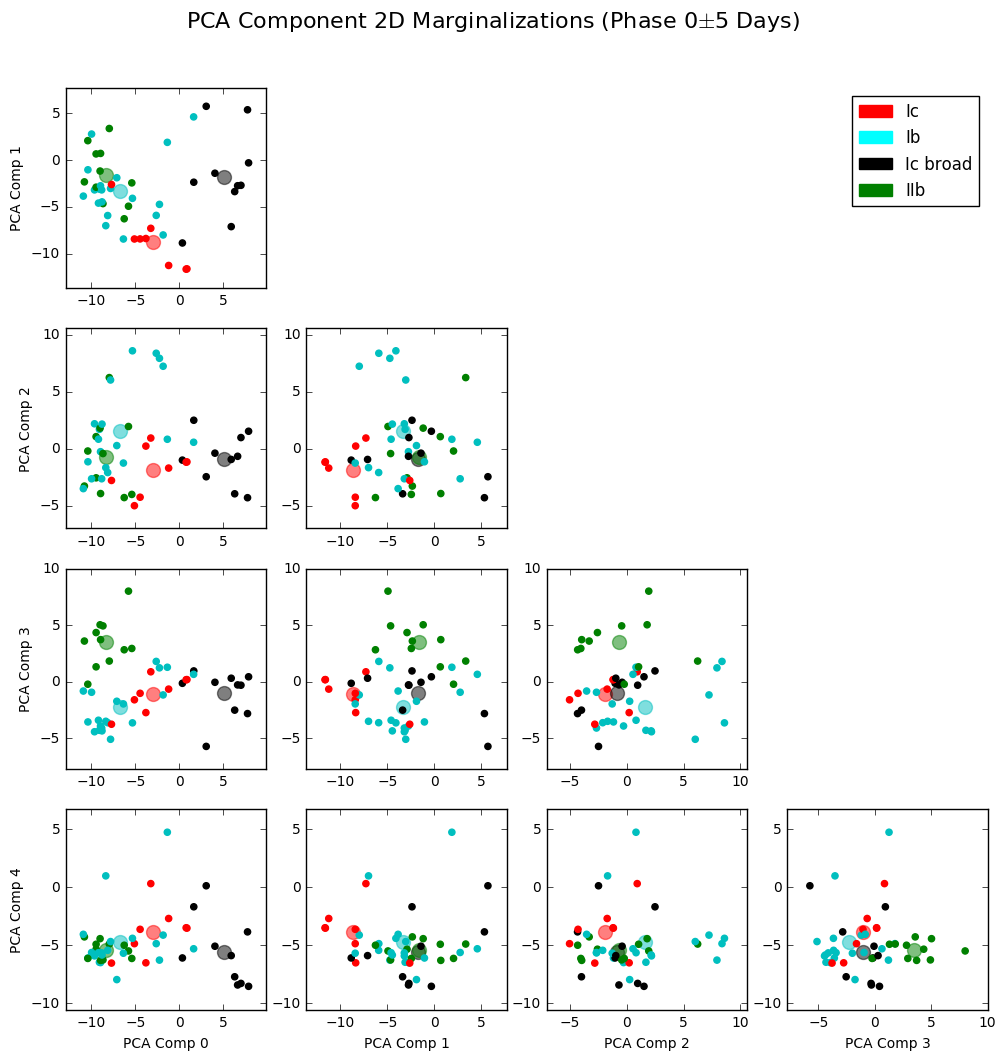

In [129]:
import matplotlib.patches as mpatches


red_patch = mpatches.Patch(color='red', label='Ic')
cyan_patch = mpatches.Patch(color='cyan', label='Ib')
black_patch = mpatches.Patch(color='black', label='Ic broad')
green_patch = mpatches.Patch(color='green', label='IIb')

colors_types = ['c', 'r', 'k', 'g']

ncomp = 5
plt.figure(figsize=(15, 15))
for i in range(ncomp):
    for j in range(ncomp):
        if i > j:
            plot_number = ncomp*i+j+1
            plt.subplot(ncomp,ncomp,plot_number)
            x = spectra_pca_matrix[:,i][color_mask]
            y = spectra_pca_matrix[:,j][color_mask]
            
            for col in colors_types:
                tmp_mask = colors==col
                xmean = np.mean(x[tmp_mask])
                ymean = np.mean(y[tmp_mask])
                plt.scatter(ymean, xmean, color=col, alpha=.5, s=100)
            
            print "(x,y) shape is (%d,%d)"%(len(x),len(y))
            plt.scatter(y,x,color=colors[color_mask],alpha=1)
            plt.xlim((np.min(spectra_pca_matrix[:,j])-2,np.max(spectra_pca_matrix[:,j])+2))
            plt.ylim((np.min(spectra_pca_matrix[:,i])-2,np.max(spectra_pca_matrix[:,i])+2))
            #plt.xlim((-5,5))
            #plt.ylim((-5,5))
            if j==0:
                plt.ylabel('PCA Comp %d'%(i))
            if i==4:
                plt.xlabel('PCA Comp %d'%(j))

                
                
plt.subplot(5,5,9)
plt.axis('off')
plt.legend(handles=[red_patch, cyan_patch, black_patch, green_patch])
plt.text(-3.0,1.3,'PCA Component 2D Marginalizations (Phase 0$\pm$5 Days)',fontsize=16)

#plt.savefig('plots/PCA_2Dcomp_phase0pm5.png')

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x6d85090>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x8c6acd0>)

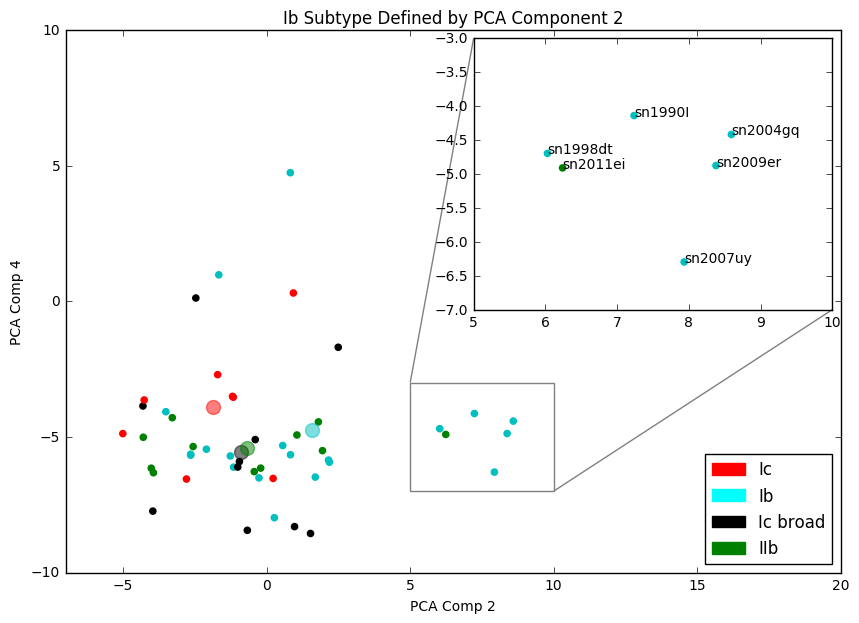

In [130]:
fig, ax = plt.subplots(figsize=(10,7))

pca_x = 2
pca_y = 4


x = spectra_pca_matrix[:,pca_x]
y = spectra_pca_matrix[:,pca_y]
plt.scatter(x,y,color=colors)

#for i, txt in enumerate(Ib_Ic_names):
#    ax.annotate(txt,(spectra_pca_matrix[:,2][i],spectra_pca_matrix[:,4][i]))


for col in colors_types:
    tmp_mask = colors==col
    xmean = np.mean(x[tmp_mask])
    ymean = np.mean(y[tmp_mask])
    plt.scatter(xmean, ymean, color=col, alpha=.5, s=100)


plt.xlabel('PCA Comp %d'%(pca_x))
plt.ylabel('PCA Comp %d'%(pca_y))
plt.xlim((-7,20))
plt.ylim((-10,10))

red_patch = mpatches.Patch(color='red', label='Ic')
cyan_patch = mpatches.Patch(color='cyan', label='Ib')
black_patch = mpatches.Patch(color='black', label='Ic broad')
green_patch = mpatches.Patch(color='green', label='IIb')
plt.legend(handles=[red_patch, cyan_patch, black_patch, green_patch],loc='lower right')
plt.title('Ib Subtype Defined by PCA Component 2')


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(ax, 2.5, loc=1) # zoom-factor: 2.5, location: upper-left

x1, x2, y1, y2 = 5, 10, -7, -3 # specify the limits (use for pca 2 vs pca 4)
#x1, x2, y1, y2 = -10, -6, -3, 0.5 # specify the limits (rogue in Ic)
#x1, x2, y1, y2 = -4, -2, -5, -2 # specify the limits (rogue in Ib)
#x1, x2, y1, y2 = 5, 10, -2, 2# specify the limits (rogue in Ib)



xzoom = np.logical_and(x>x1, x<x2)
yzoom = np.logical_and(y>y1,y<y2)
zoom_mask = np.logical_and(xzoom, yzoom)


for i, txt in enumerate(Ib_Ic_names[zoom_mask]):
    axins.annotate(txt,(x[zoom_mask][i],y[zoom_mask][i]))


axins.scatter(spectra_pca_matrix[:,pca_x][zoom_mask],spectra_pca_matrix[:,pca_y][zoom_mask],color=colors[zoom_mask])

for col in colors_types:
    tmp_mask = colors==col
    xmean = np.mean(x[tmp_mask])
    ymean = np.mean(y[tmp_mask])
    axins.scatter(xmean, ymean, color=col, alpha=.5, s=100)


axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits




#plt.yticks(visible=False)
#plt.xticks(visible=False)

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
#plt.savefig('plots/PCA_Comp2_subtype_zoomin_phase15pm5.png')

In [114]:
evecs.shape

(49, 207)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False]
[  3.27817330e-02  -1.22055947e-01   7.05470209e-02   3.65582618e-02
  -8.99554527e-02  -2.71228835e-01  -1.18279419e-01  -2.00896701e-02
   5.92174345e-02  -1.08838097e-01  -1.63597764e-01   1.04535780e-01
   1.32859746e-01   1.95172471e-01   2.68814782e-01   3.40568829e-01
   3.67004531e-01   1.63071976e-01   7.99883429e-02   1.40412804e-01
   9.88709868e-02   1.19641895e-01  -4.98355494e-03  -3.33075209e-02
   3.65582618e-02  -8.42906596e-02   1.38990890e-02  -1.20702615e-03
   8.23429583e-03   6.86587565e-02   5.35526413e-02   1.53630654e-01
   1.08312309e-01  -1.27720741e-01  -2.19779345e-02  -6.72962800e-02
  -8.24023952e-02  -1.63131413e-02  -4.27488429e-02  -7.67376020e-02
  -8.61789

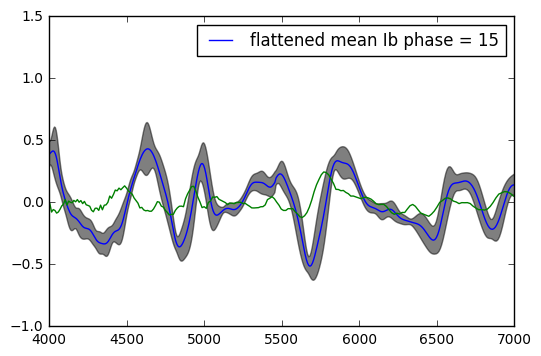

In [115]:
from scipy.io.idl import readsav
tp='Ib'
s = readsav('PCvsTemplates/meanspec%s_1specperSN_15.sav'%tp)
plt.fill_between(s.wlog, s.fmean + s.fsdev, s.fmean - s.fsdev, 
                    color = 'k', alpha = 0.5)
plt.plot(s.wlog, s.fmean, label="flattened mean %s phase = 15"%tp)


#sp = 'sn1983N'
sp='sn2006jc'
m = Ib_Ic_names==sp
print m
print spectra_matrix[m][0]
#plt.plot(wavelengths,spectra_matrix[m][0]/np.max(spectra_matrix[m][0]))
plt.plot(wavelengths,evecs[2])
plt.xlim((4000,7000))
plt.legend()



In [131]:
#Ib_mask = colors=='c'
Ib_comp2_sub = np.logical_and(Ib_mask,spectra_pca_matrix[:,2]>5)
Ib_comp2_norm = np.logical_and(Ib_mask, spectra_pca_matrix[:,2]<5)

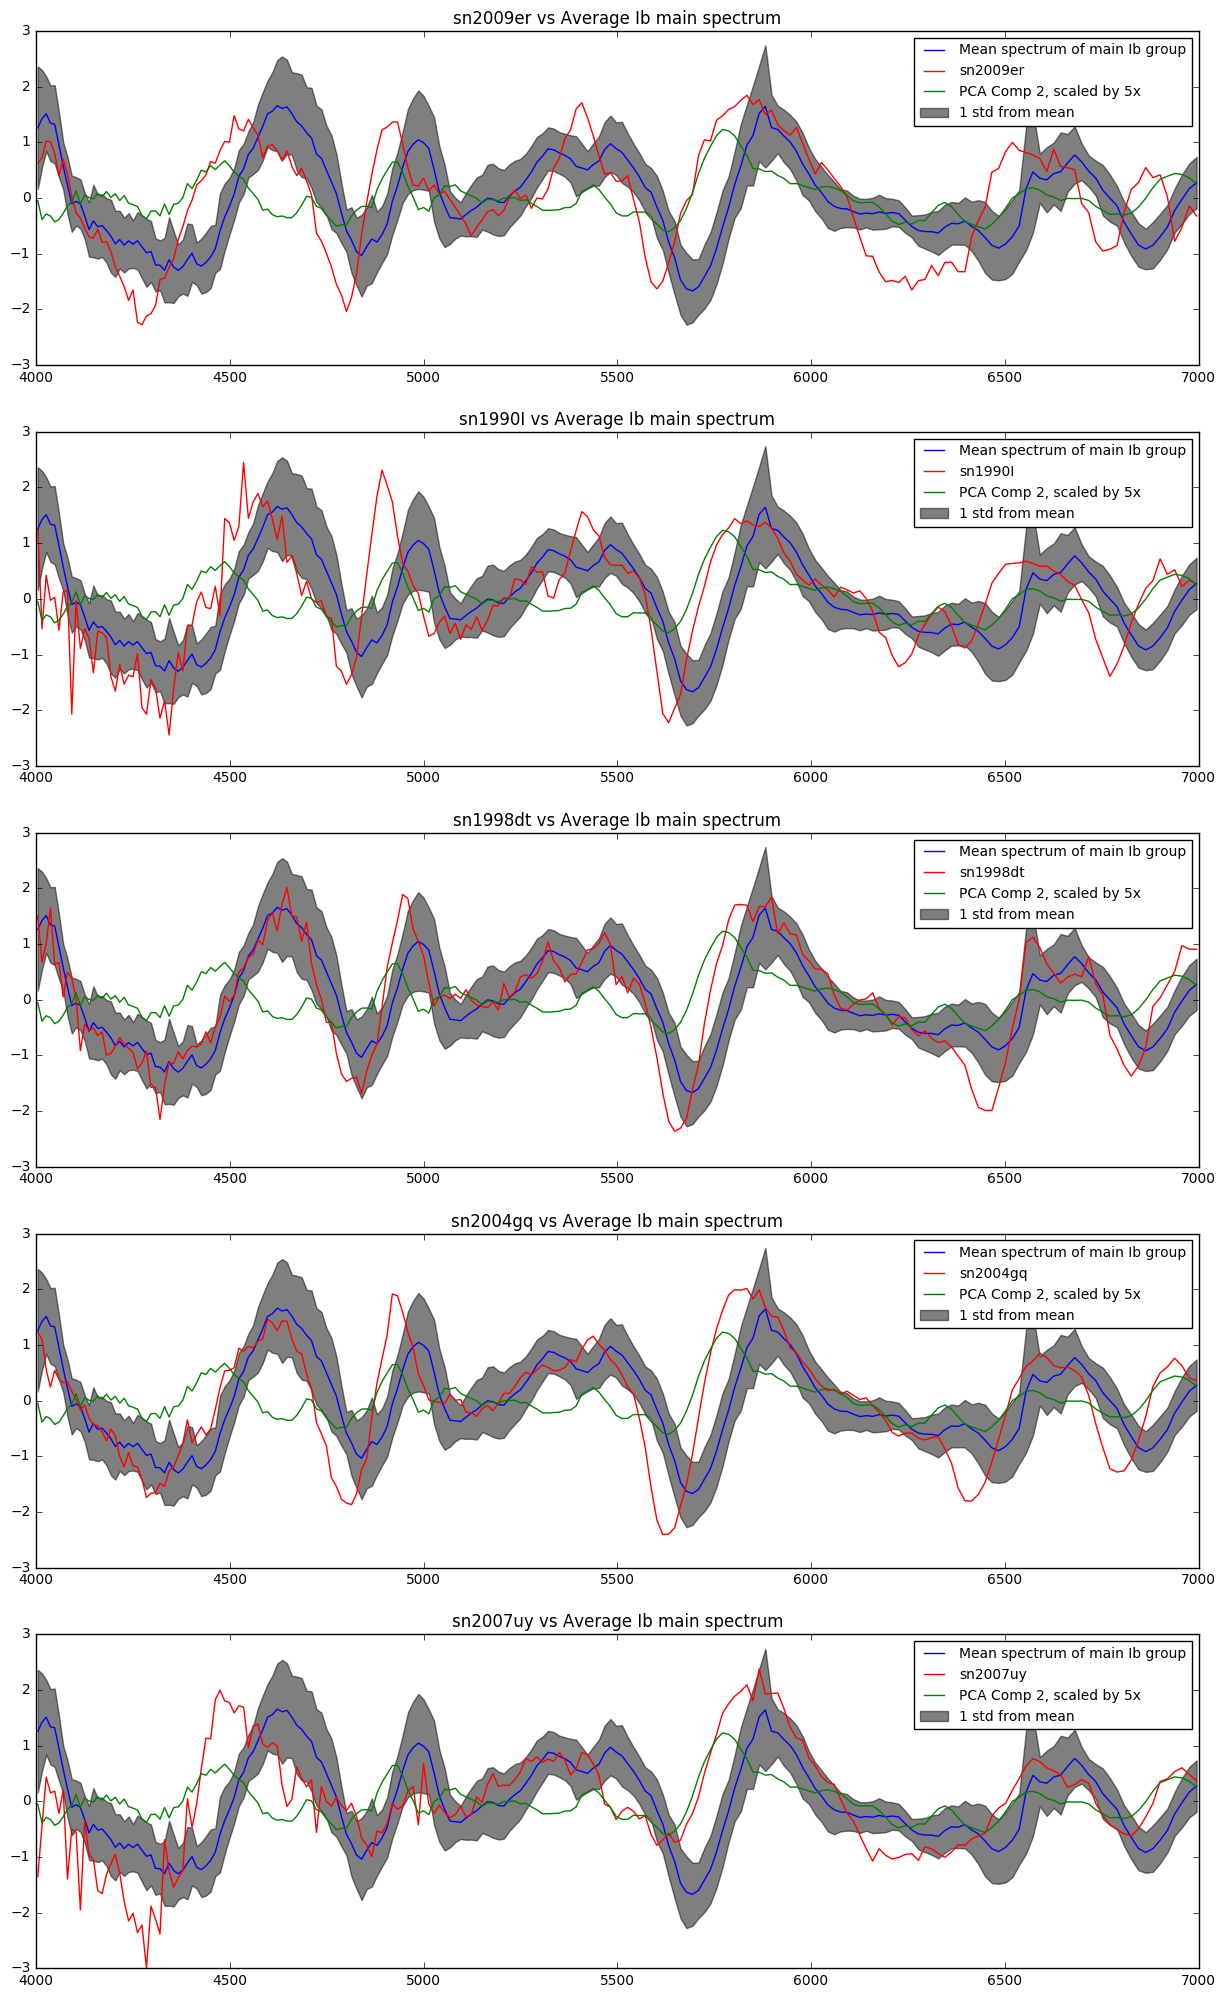

In [132]:
Ib_norm_mean_spec = np.mean(spectra_matrix[Ib_comp2_norm],axis=0)
Ib_norm_std_spec = np.std(spectra_matrix[Ib_comp2_norm],axis=0)

names = Ib_Ic_names[np.logical_and(zoom_mask,Ib_mask)]

f=plt.figure(figsize=(15,25))
for i,name in enumerate(names):
    plt.subplot(5,1,i+1)
    plt.plot(wavelengths, Ib_norm_mean_spec, color='b', label='Mean spectrum of main Ib group')
    plt.fill_between(wavelengths[:,0], Ib_norm_mean_spec + Ib_norm_std_spec, Ib_norm_mean_spec - Ib_norm_std_spec, 
                     color='k', alpha=0.5, label='1 std from mean')
    m = Ib_Ic_names==name
    plt.plot(wavelengths,spectra_matrix[m][0],color='r',label=name)
    plt.plot(wavelengths,5*evecs[2],color='g',label='PCA Comp 2, scaled by 5x')
    plt.legend(loc='upper right',prop={'size':10})
    plt.title(name+' vs Average Ib main spectrum')
    
#f.savefig('plots/Ib_subtype_phase15pm5.png')

In [233]:
spectra_pca_matrix.shape

(49, 49)

# Reconstruct Spectra with PCA

In [245]:
def reconstruct_SN_type(pca_spec_mat, spec_names, ncomp, col, sn_type, threshhold=None, fig=None, ax=None):
    if threshhold!=None:
        bar_y = []
        for spec in pca_spec_mat:
            for i in range(spectra_pca_matrix.shape[1]):
                perc_reconstruct = percent_reconstruct(spec, i)
                if perc_reconstruct > threshhold:
                    bar_y.append(i)
                    break
        bar_y = np.array(bar_y)
        ylabel = '# of PCA Components'
        title = 'SNe '+sn_type+' Reconstruct to %.2f Accuracy'%(threshhold)
        
    else:
        bar_y = []
        for spec in pca_spec_mat:
            perc_reconstruct = percent_reconstruct(spec, ncomp)
            bar_y.append(perc_reconstruct)
        bar_y = np.array(bar_y)
        ylabel = 'Percent of spectrum reconstructed'
        title = 'SNe '+sn_type+' with %d components'%(ncomp)

    
    x_loc = np.arange(1,pca_spec_mat.shape[0]+1)
    width = 0.8
    if fig==None or ax==None:
        fig, ax = plt.subplots(figsize=(10,10))
    rects = ax.bar(x_loc, bar_y, width, color=col)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x_loc + width / 2.0)
    ax.set_xticklabels(spec_names,rotation=60)
    ax.set_xlim((0,x_loc[-1]))
    if threshhold!=None:
        ax.set_ylim((0,bar_y.max()))
    else:
        ax.set_ylim((0,1))
    return fig, ax

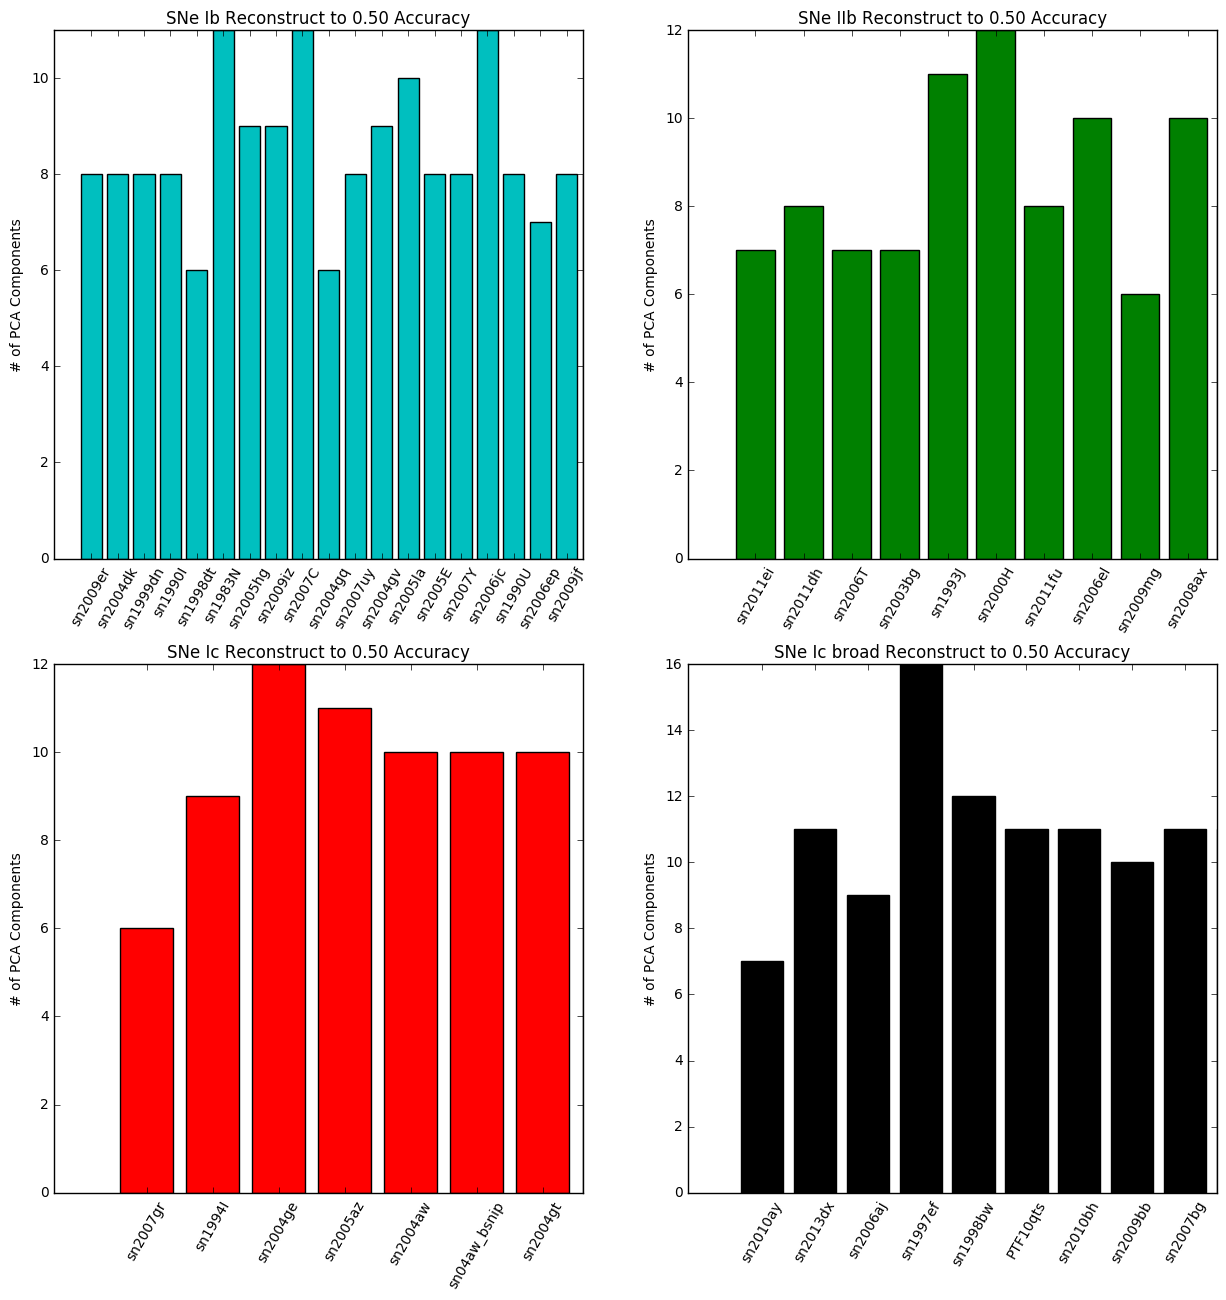

In [246]:
bar_fig, ax_arr = plt.subplots(2,2,figsize=(15,15))
ncomp_bar = 20

f,a = reconstruct_SN_type(spectra_pca_matrix[Ib_mask], Ib_Ic_names[Ib_mask], ncomp=ncomp_bar, threshhold=.5,
                          col='c', sn_type='Ib',fig=bar_fig,ax=ax_arr[0,0])

f,a = reconstruct_SN_type(spectra_pca_matrix[IIb_mask], Ib_Ic_names[IIb_mask], ncomp=ncomp_bar, threshhold=.5,
                          col='g', sn_type='IIb',fig=bar_fig,ax=ax_arr[0,1])

f,a = reconstruct_SN_type(spectra_pca_matrix[Ic_mask], Ib_Ic_names[Ic_mask], ncomp=ncomp_bar, threshhold=.5,
                          col='r', sn_type='Ic',fig=bar_fig,ax=ax_arr[1,0])

f,a = reconstruct_SN_type(spectra_pca_matrix[Ic_broad_mask], Ib_Ic_names[Ic_broad_mask], ncomp=ncomp_bar, threshhold=.5,
                          col='k', sn_type='Ic broad',fig=bar_fig,ax=ax_arr[1,1])

In [200]:
ax_arr

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12aa8e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x125f49d0>]], dtype=object)

In [ ]:
fig, ax = plt.subplots

n pca components =  5
[ 0.39460256  0.45934328  0.44386031  0.39480051  0.45751102  0.38566756
  0.41725658  0.42793986  0.32598574  0.48041228  0.40039494  0.41187187
  0.18122952  0.37585962  0.41098286  0.2134163   0.43423867  0.44341561
  0.41493596  0.43992189]
n pca components =  5
[ 0.41494741  0.47156476  0.44809431  0.45879893  0.35110764  0.32474487
  0.39455983  0.36985364  0.47367931  0.36255939  0.4313566 ]
n pca components =  5
[ 0.44815367  0.36257044  0.22951561  0.36337357  0.34148819  0.34274007
  0.37659086  0.32972691]
n pca components =  5
[ 0.41407664  0.37199281  0.39823639  0.29787383  0.31981492  0.21119063
  0.29885004  0.34115415  0.18202723  0.35436068]


(<matplotlib.figure.Figure at 0x1040d4d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12536190>)

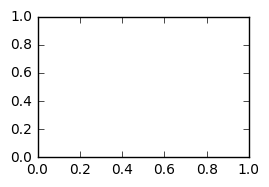

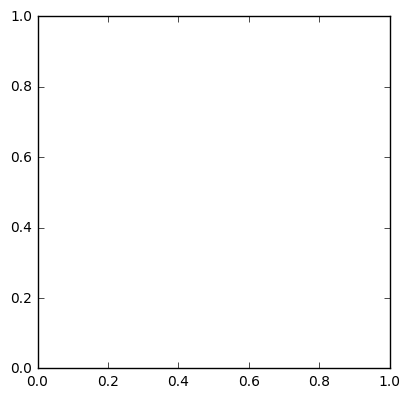

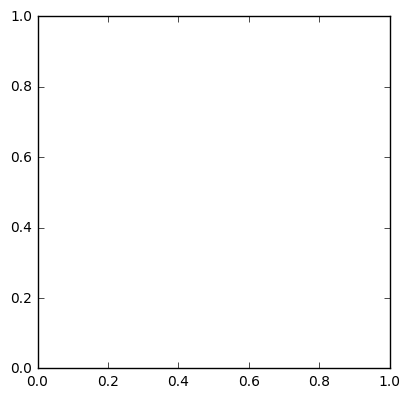

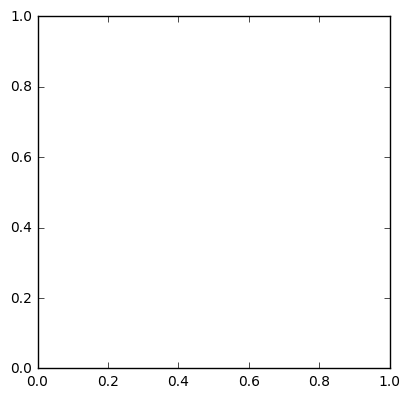

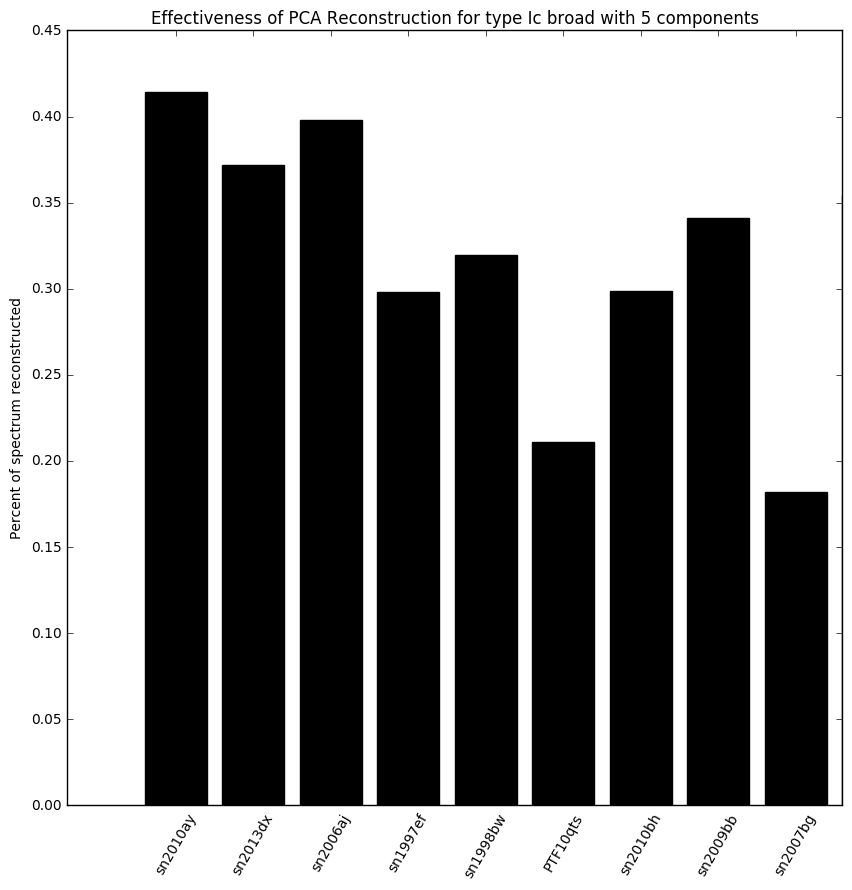

In [193]:
plt.subplot(2,2,1)
reconstruct_SN_type(spectra_pca_matrix[Ib_mask], Ib_Ic_names[Ib_mask], ncomp=5, col='c', sn_type='Ib')

plt.subplot(2,2,2)
reconstruct_SN_type(spectra_pca_matrix[IIb_mask], Ib_Ic_names[IIb_mask], ncomp=5, col='g', sn_type='IIb')

plt.subplot(2,2,3)
reconstruct_SN_type(spectra_pca_matrix[Ic_mask], Ib_Ic_names[Ic_mask], ncomp=5, col='r', sn_type='Ic')

plt.subplot(2,2,4)
reconstruct_SN_type(spectra_pca_matrix[Ic_broad_mask], Ib_Ic_names[Ic_broad_mask], ncomp=5, col='k', sn_type='Ic broad')

In [ ]:
fig, ax = subplots

In [146]:

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r', yerr=men_std)

women_means = (25, 32, 34, 20, 25)
women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, women_means, width, color='y', yerr=women_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))

In [136]:
a==None

True

In [147]:
assert a==1, 'test'

AssertionError: test

# TSNE

In [590]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [591]:
ncomp_tsne = 2
model = TSNE(n_components=ncomp_tsne, random_state=0)

In [592]:
tsne_spec = model.fit_transform(spectra_pca_matrix)

(x,y) shape is (95,95)


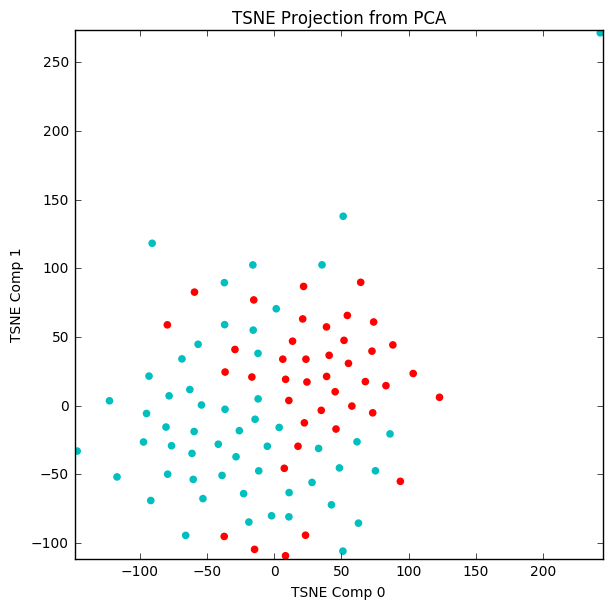

In [593]:
plt.figure(j, figsize=(15, 15))
for i in range(ncomp_tsne):
    for j in range(ncomp_tsne):
        if i > j:
            plot_number = ncomp_tsne*i+j+1
            plt.subplot(ncomp_tsne,ncomp_tsne,plot_number)
            x = tsne_spec[:,i]
            y = tsne_spec[:,j]
            print "(x,y) shape is (%d,%d)"%(len(x),len(y))
            plt.scatter(y,x,color=colors)
            plt.xlim((np.min(tsne_spec[:,j])-2,np.max(tsne_spec[:,j])+2))
            plt.ylim((np.min(tsne_spec[:,i])-2,np.max(tsne_spec[:,i])+2))
            #plt.xlim((-5,5))
            #plt.ylim((-5,5))
            if j==0:
                plt.ylabel('TSNE Comp %d'%(i))
            if i==ncomp_tsne-1:
                plt.xlabel('TSNE Comp %d'%(j))
plt.title('TSNE Projection from PCA')
#plt.savefig('TSNE.pdf')

# ICA

In [604]:
spectra_pca_matrix.shape

(95, 95)

In [605]:
cov = np.cov(spectra_pca_matrix.T)
off_diag = []
diag = []
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        if i==j: 
            diag.append(cov[i,j])
        else:
            off_diag.append(cov[i,j])
off_diag = np.array(off_diag)
diag = np.array(diag)

In [606]:
np.abs(off_diag).sum()

1.5687872233473598e-12

In [607]:
spectra_pca_matrix.shape

(95, 95)

In [608]:
n_pca_dim = 95
spectra_matrix_pca_white = spectra_pca_matrix[:,0:n_pca_dim]


In [609]:
pca_eigs = pca.explained_variance_[0:n_pca_dim]

In [610]:
spectra_matrix_pca_white = spectra_matrix_pca_white/pca_eigs

In [611]:
from sklearn.decomposition import FastICA

In [612]:
n_ica_comp = 95
ica = FastICA(n_components=n_ica_comp)
ica_spec_matrix = ica.fit_transform(spectra_matrix_pca_white)

In [613]:
ica_spec_matrix.shape

(95, 95)

In [614]:
ica.components_.shape

(95, 95)

(x,y) shape is (95,95)
(x,y) shape is (95,95)
(x,y) shape is (95,95)
(x,y) shape is (95,95)
(x,y) shape is (95,95)
(x,y) shape is (95,95)
(x,y) shape is (95,95)
(x,y) shape is (95,95)
(x,y) shape is (95,95)
(x,y) shape is (95,95)


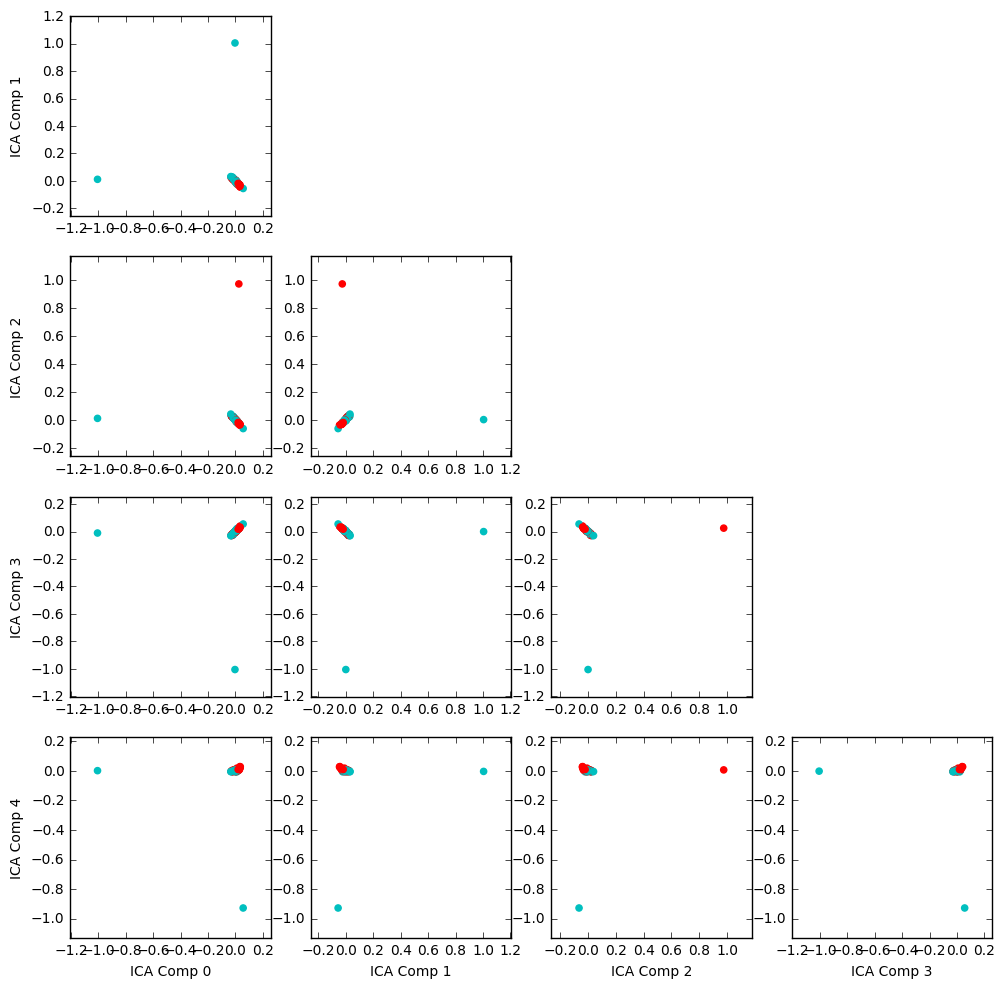

In [615]:
ica_dim = 5
plt.figure(j, figsize=(15, 15))
for i in range(ica_dim):
    for j in range(ica_dim):
        if i > j:
            plot_number = ica_dim*i+j+1
            plt.subplot(ica_dim,ica_dim,plot_number)
            x = ica_spec_matrix[:,i]
            y = ica_spec_matrix[:,j]
            print "(x,y) shape is (%d,%d)"%(len(x),len(y))
            plt.scatter(y,x,color=colors)
            plt.xlim((np.min(ica_spec_matrix[:,j])-.2,np.max(ica_spec_matrix[:,j])+.2))
            plt.ylim((np.min(ica_spec_matrix[:,i])-.2,np.max(ica_spec_matrix[:,i])+.2))
            #plt.xlim((-5,5))
            #plt.ylim((-5,5))
            if j==0:
                plt.ylabel('ICA Comp %d'%(i))
            if i==4:
                plt.xlabel('ICA Comp %d'%(j))

spectra matrix  (95, 207)
ica evecs  (95, 95)
spectra true  (207,)
ica_coeff  (95,)
ica coeff[:n]  (0,)
[]
ica evecs[:n]  (0, 95)
[]
arg  (95,)
inv ica coeff  [[ -1.07929819e-01  -1.97427015e-01  -2.89539375e-02  -1.18712664e-01
   -9.60827004e-01  -5.43749219e-01  -4.78963322e-01   6.84047041e-01
    6.97892077e-02   3.05756160e-01  -1.09650982e+00   3.61466965e-01
   -4.99911443e-01   7.64444075e-01   9.36488382e-01   4.96974135e-01
    6.59124859e-01   5.05316046e-01  -1.22321224e+00  -1.39797090e-01
    1.38177368e+00   1.99860306e+00   9.60324506e-01  -4.86684159e-02
    7.08497841e-01  -2.29090076e+00  -1.40566059e+00  -2.91784614e+00
   -2.00749933e+00   4.61717233e-01   1.42304914e+00   2.92050487e-01
   -8.86857057e-01  -1.59905063e+00  -1.80739644e+00   1.81583177e+00
    7.44689661e-01  -2.07735226e+00   1.70564201e+00  -1.19751029e+00
   -3.47963889e+00  -7.01964941e-01   1.77640083e+00   9.75371459e-01
    4.62318599e+00  -3.73584804e-02   5.80937885e-01  -1.93487945e+00
 

/home/data/mew488/virtualenvs/mypy2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: shapes (1,95) and (0,207) not aligned: 95 (dim 1) != 0 (dim 0)

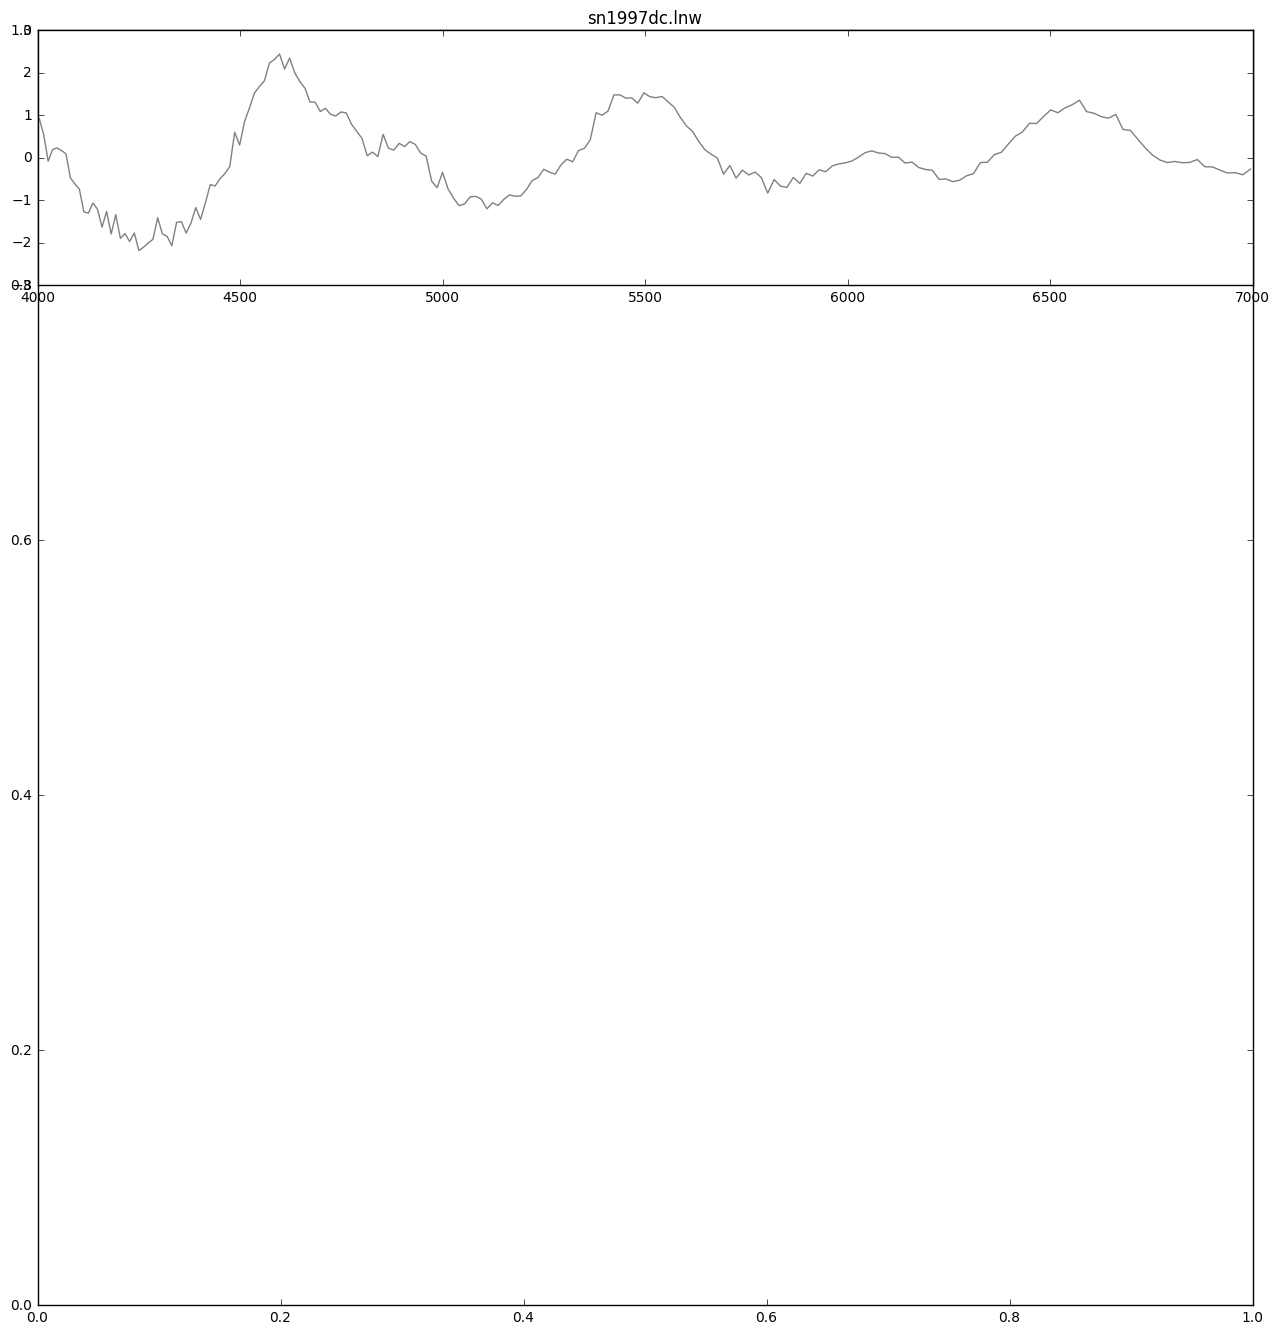

In [620]:
# Recreate 10 random spectra using the PCA decomposition
random_spec = np.random.randint(0,spectra_matrix.shape[0],1)
n_ica_components = [0,1,5,10,n_ica_comp]

ica_evecs = ica.components_.T

for j,spec in enumerate(random_spec):
    spec_name = Ib_Ic_names[spec]
    print 'spectra matrix ',spectra_matrix.shape
    true_spec = spectra_matrix[spec]
    
    print 'ica evecs ',ica_evecs.shape
    print 'spectra true ',spectra_matrix[spec].shape
    #ica_coeff = np.dot(ica_evecs, spectra_matrix_pca_white[spec])
    ica_coeff = ica_spec_matrix[spec]
    print 'ica_coeff ',ica_coeff.shape
    
    
    #------------------------------------------------------------
    # Plot the sequence of reconstructions
    fig = plt.figure(j, figsize=(15, 15))
    plt.title(spec_name)
    fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

    for i, n in enumerate(n_ica_components):#, len(pca.components_)]):
        ax = fig.add_subplot(511 + i)
        ax.plot(wavelengths, true_spec, '-', c='gray')
        print 'ica coeff[:n] ',ica_coeff[:n].shape
        print ica_coeff[:n]
        print 'ica evecs[:n] ', ica_evecs[:n].shape
        print ica_evecs[:n]
        arg = np.dot(ica_coeff[:n], ica_evecs[:n])
        print 'arg ',arg.shape
        inv_ica_coeff = ica.inverse_transform(arg)
        print 'inv ica coeff ',inv_ica_coeff
        pca_from_ica_coeff = pca_eigs*inv_ica_coeff
        print pca_from_ica_coeff
        print 'pca from ica ',pca_from_ica_coeff.shape
        
        print 'evecs ', evecs.shape
        print 'mat mult: ',pca_from_ica_coeff.shape,evecs[:n_pca_dim].shape
        ax.plot(wavelengths, (np.dot(pca_from_ica_coeff, evecs[:n])).T, '-k')
        
        if i < 3:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
            
        ax.set_ylim(-5, 5)
        ax.set_ylabel('flux')

        if n == 0:
            text = "mean"
        elif n == 1:
            text = "mean + 1 component\n"
            text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
        else:
            text = "mean + %i components\n" % n
            text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
            
        ax.text(0.02, 0.93, text, fontsize=20,ha='left', va='top', transform=ax.transAxes)

        fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')

In [619]:
evecs[:0]

array([], shape=(0, 207), dtype=float64)

In [488]:
np.dot(spectra_matrix)

array([[  0.        ,   2.54536798,   2.45263803, ...,   1.26652602,
         -7.54670957,   0.76669039],
       [ -2.54536798,   0.        ,   2.75406394, ...,   4.11015555,
         -0.78691051,   6.22109681],
       [ -2.45263803,  -2.75406394,   0.        , ..., -10.19891052,
          2.55481422,   0.13107596],
       ..., 
       [ -1.26652602,  -4.11015555,  10.19891052, ...,   0.        ,
          0.20610881,   0.14847399],
       [  7.54670957,   0.78691051,  -2.55481422, ...,  -0.20610881,
          0.        ,  -0.03443815],
       [ -0.76669039,  -6.22109681,  -0.13107596, ...,  -0.14847399,
          0.03443815,   0.        ]])

## Kernel PCA

In [17]:
from sklearn.decomposition import KernelPCA

In [72]:
spectra_matrix
n_comp = 50

In [73]:
kpca = KernelPCA(kernel='rbf', fit_inverse_transform=True, n_components=n_comp)
k_dat = kpca.fit_transform(spectra_matrix)

In [75]:
kevecs = kpca.alphas_[0:n_comp]
kevals = kpca.lambdas_[0:n_comp]/np.sum(kpca.lambdas_)
kevals_cs = kevals.cumsum()



In [76]:
k_back_evecs = kpca.inverse_transform(kevecs)

In [77]:
k_back_evecs.shape

(50, 414)

In [78]:
print kevals_cs[10:20]
print evals_cs[10:20]

[ 0.5769039   0.59465683  0.61072274  0.62639106  0.64095084  0.6549047
  0.66833485  0.68161102  0.69465331  0.70738347]
[ 0.76518044  0.779341    0.79194409  0.80260677  0.81206388  0.82138326
  0.83023832  0.83810981  0.84531566  0.85226031]


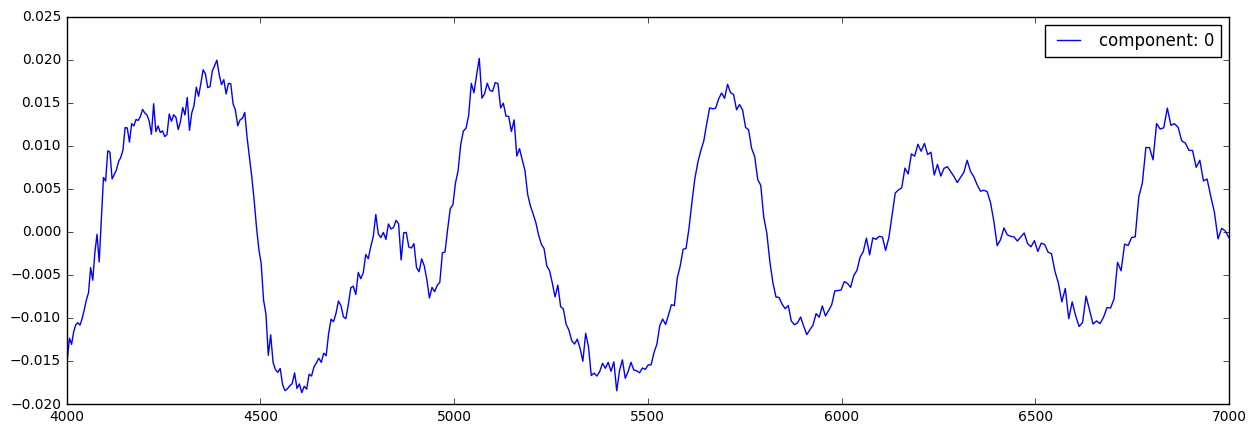

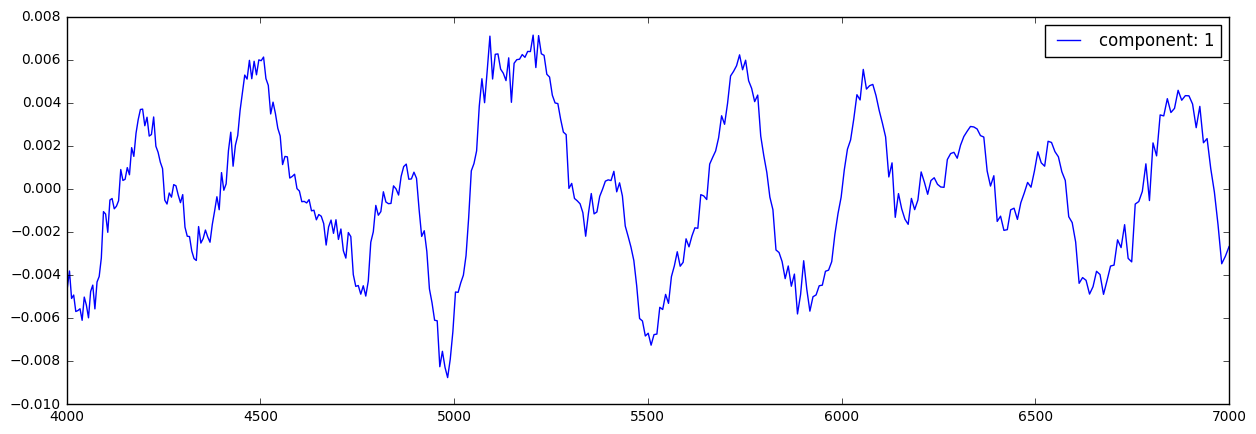

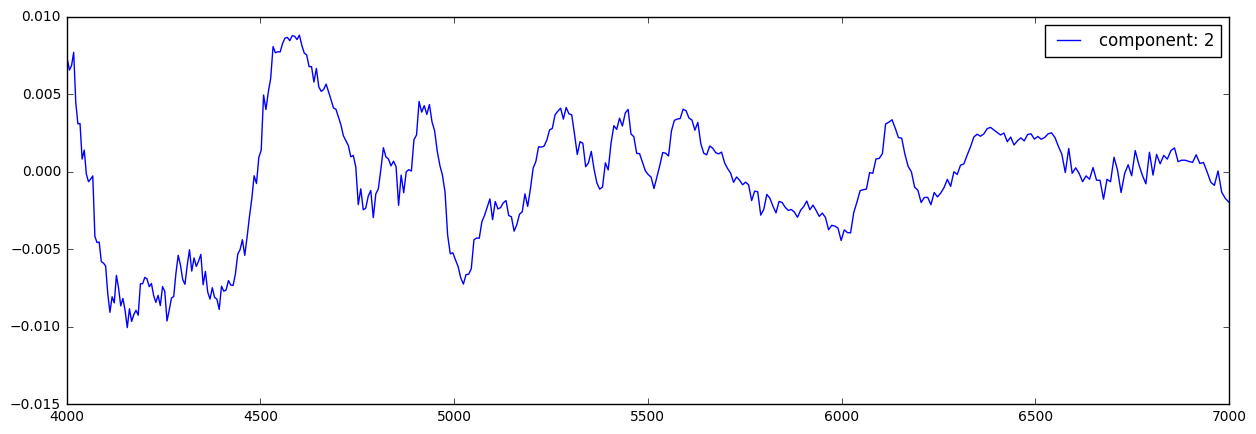

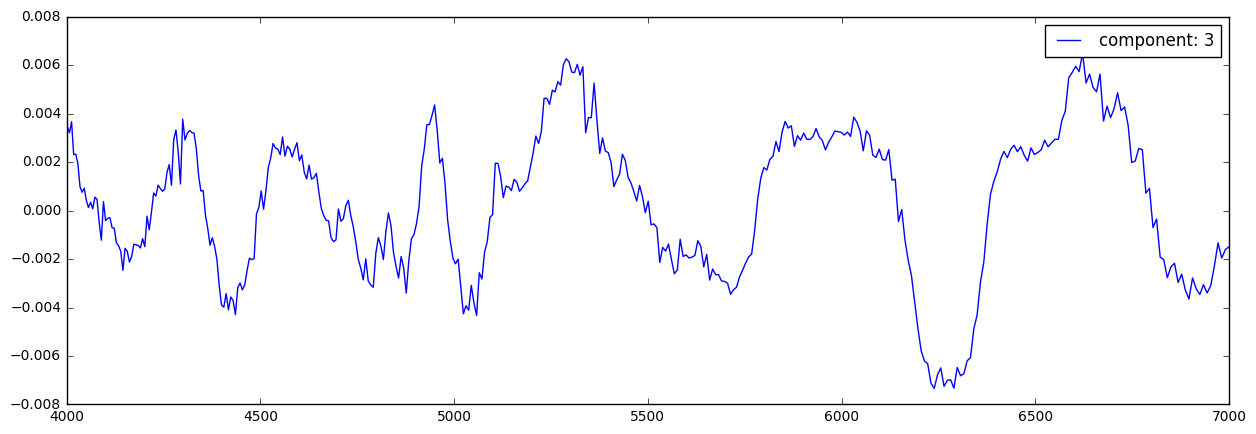

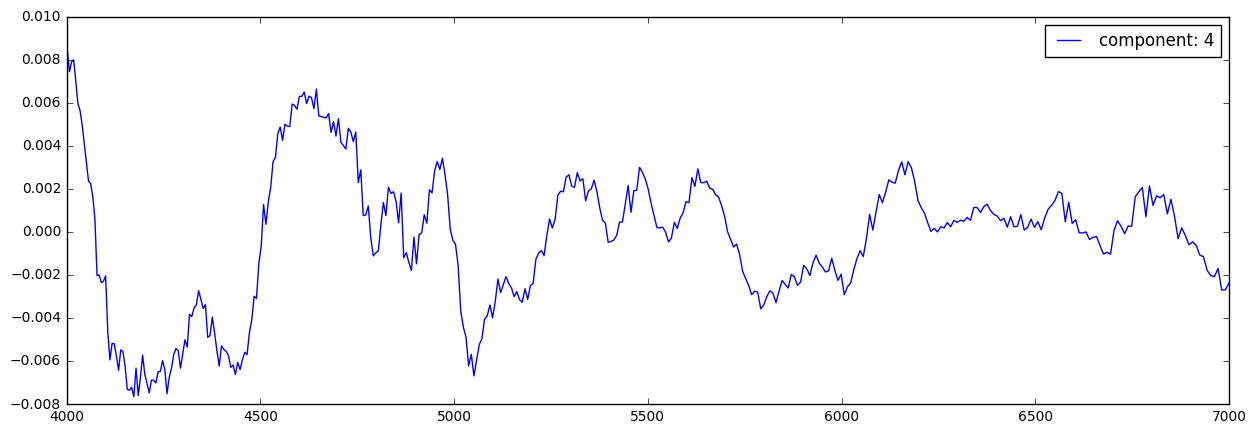

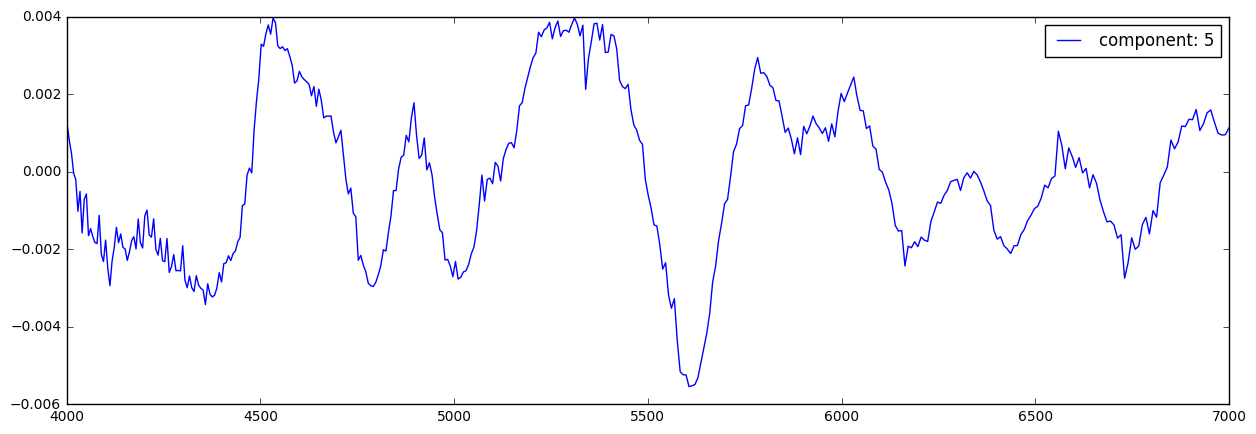

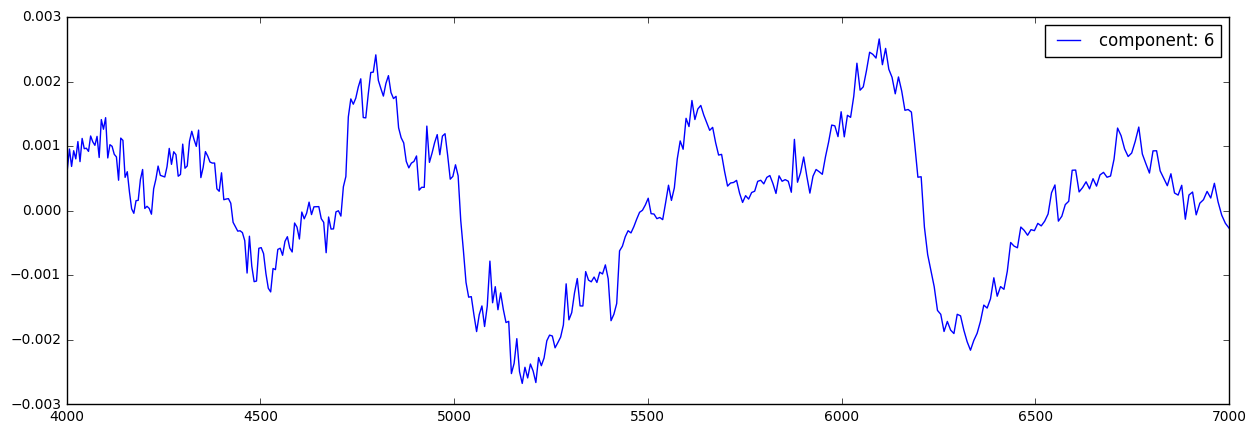

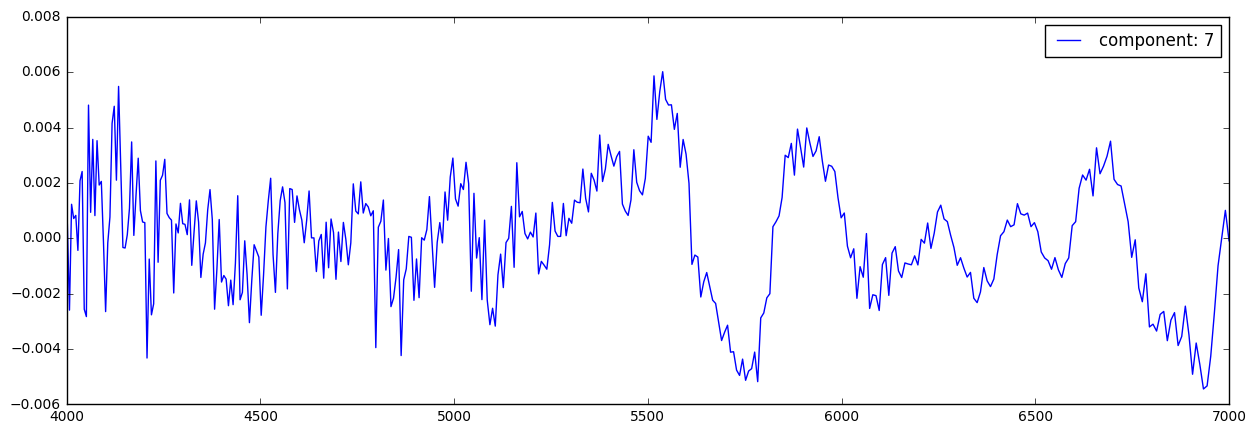

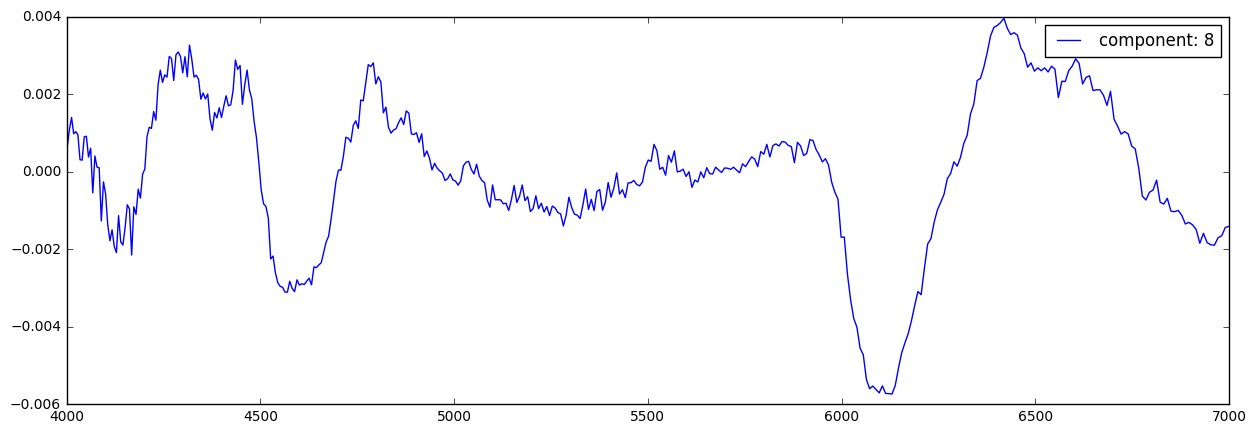

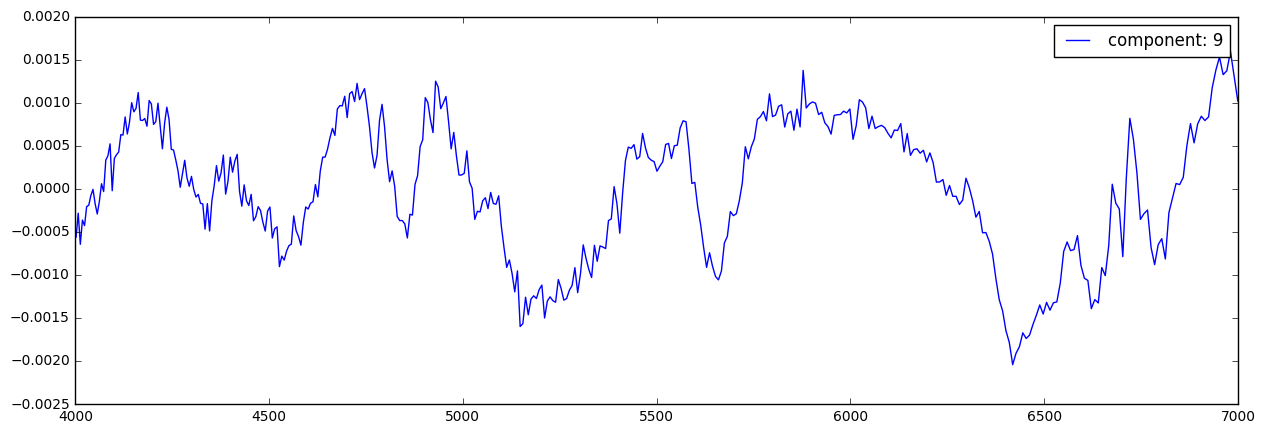

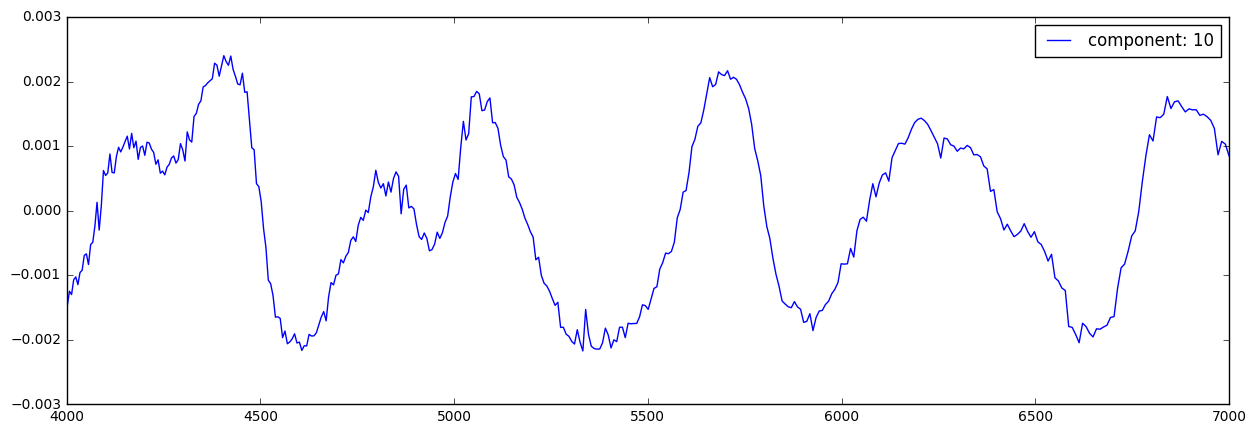

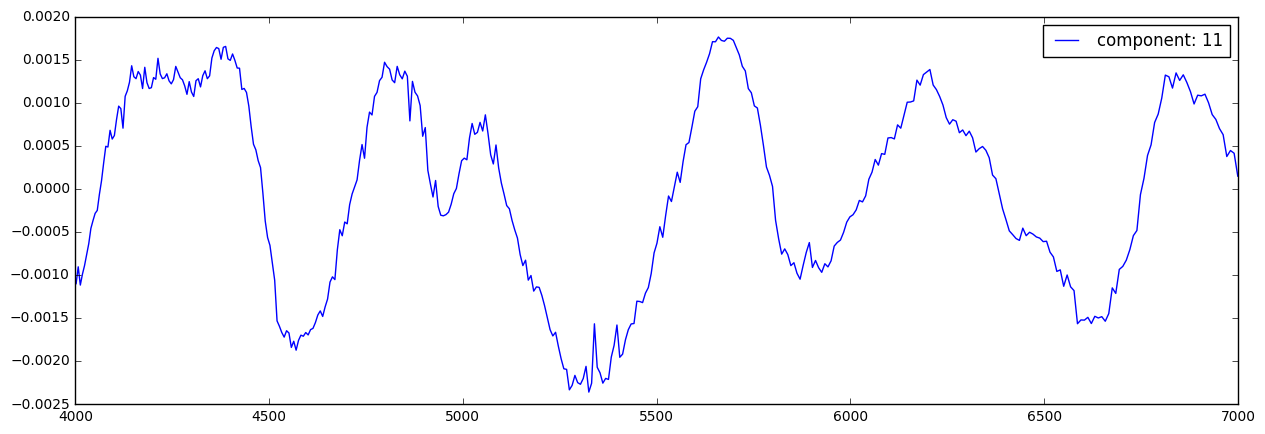

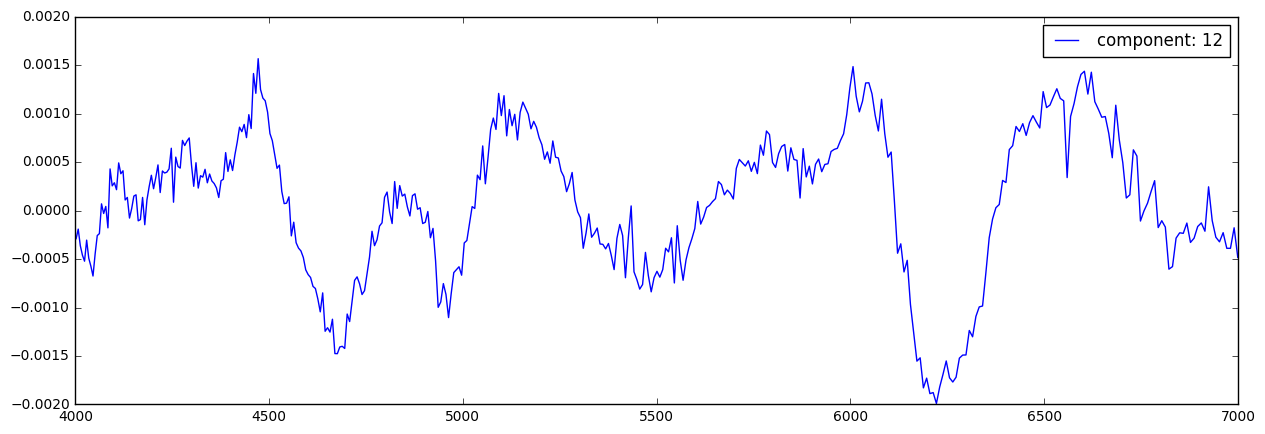

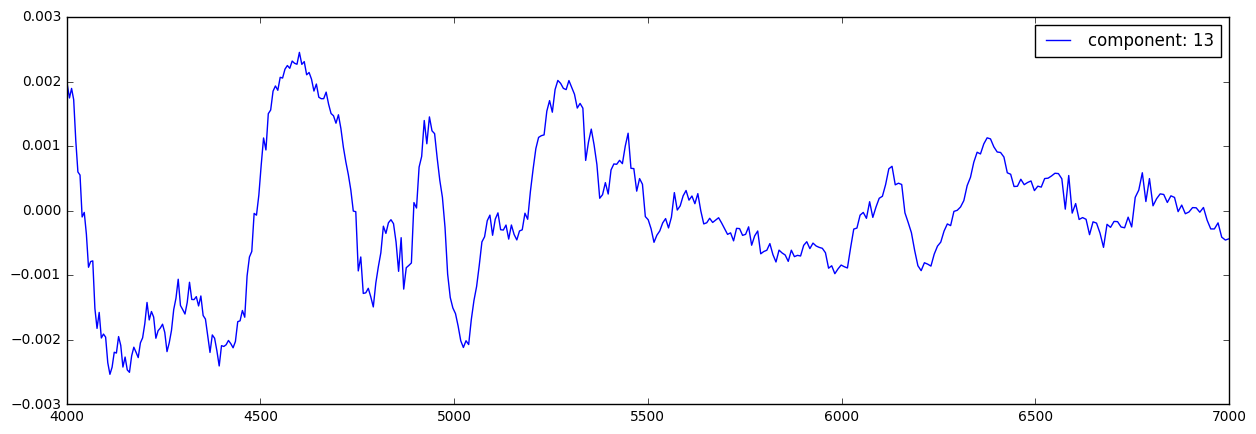

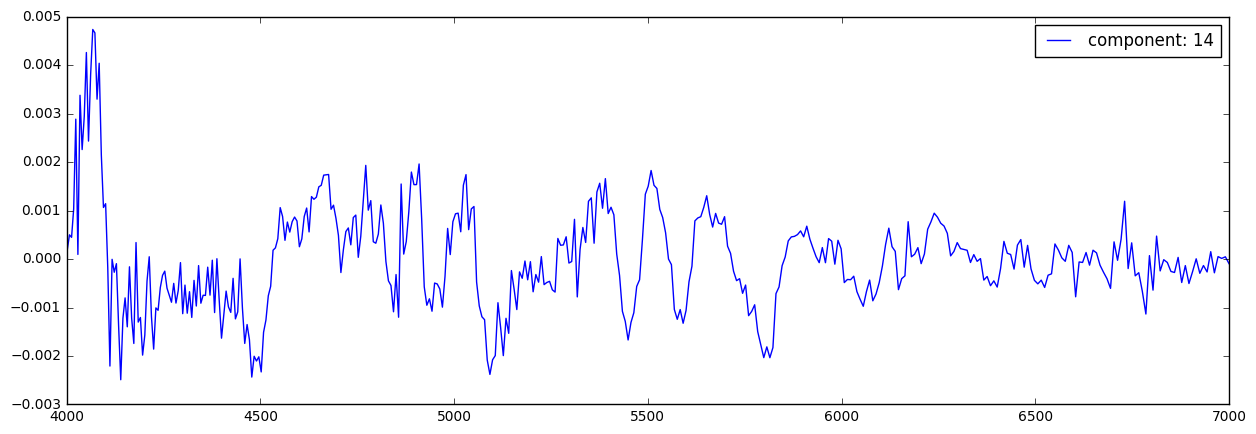

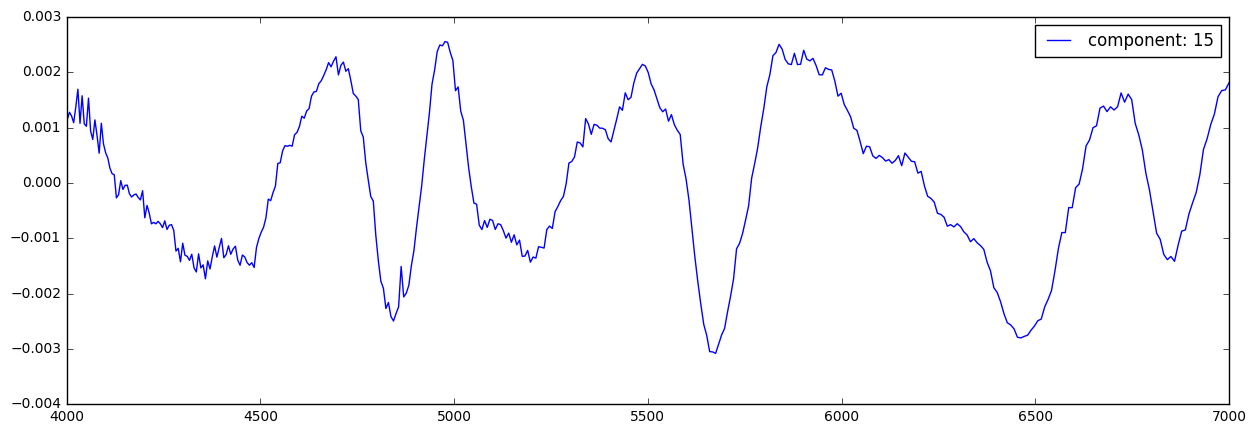

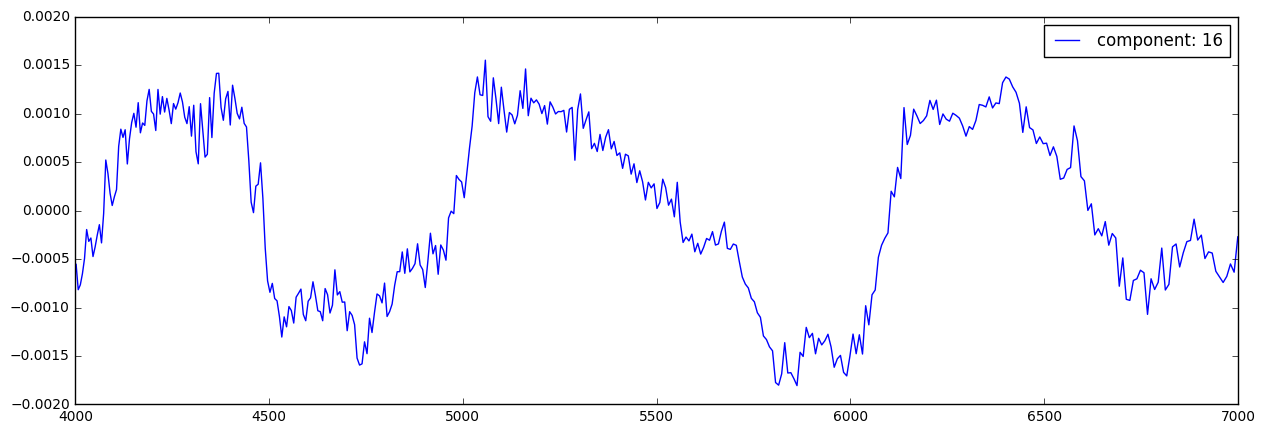

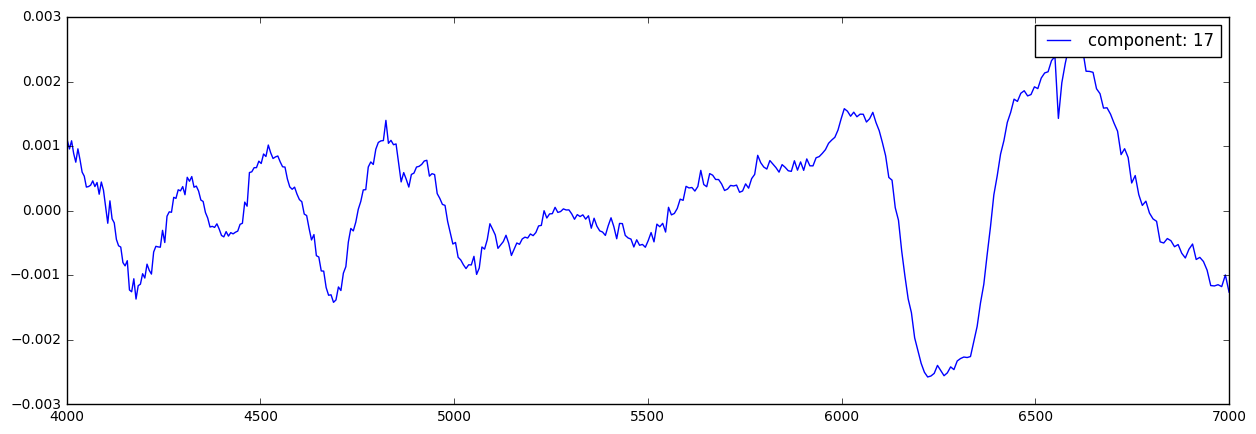

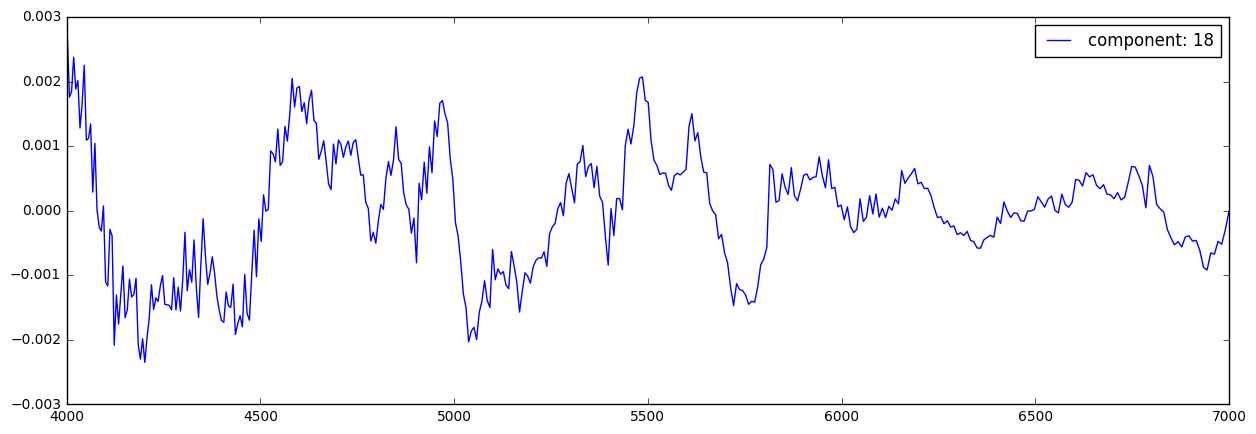

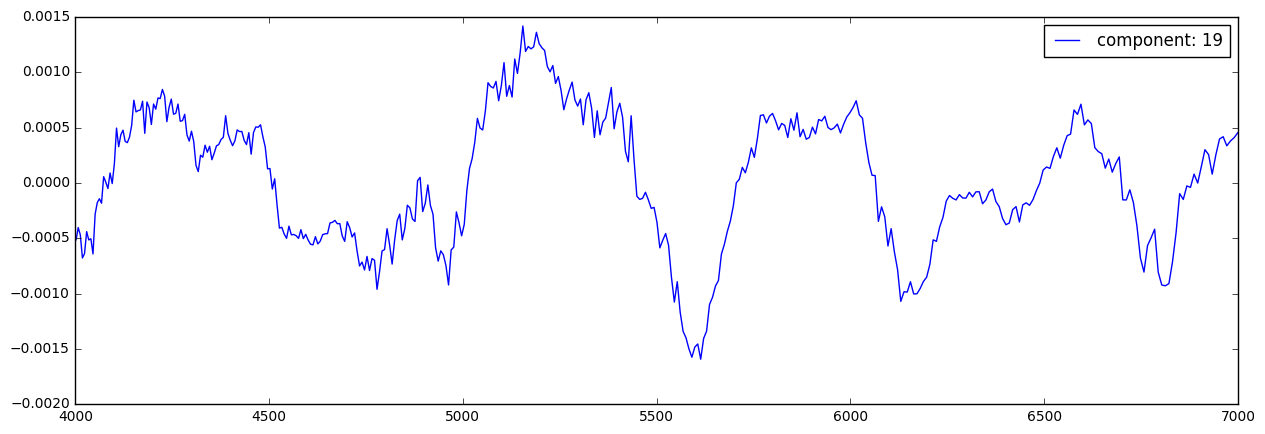

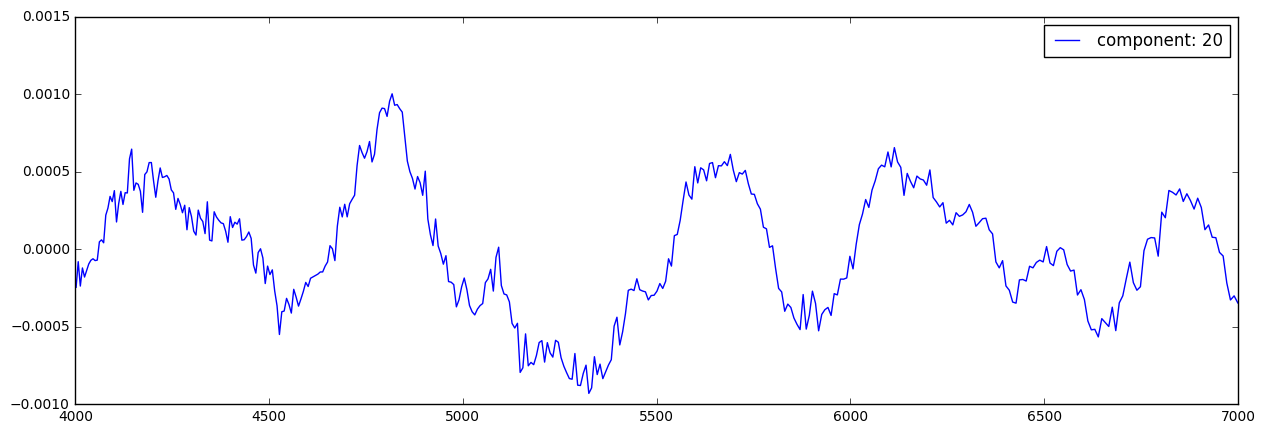

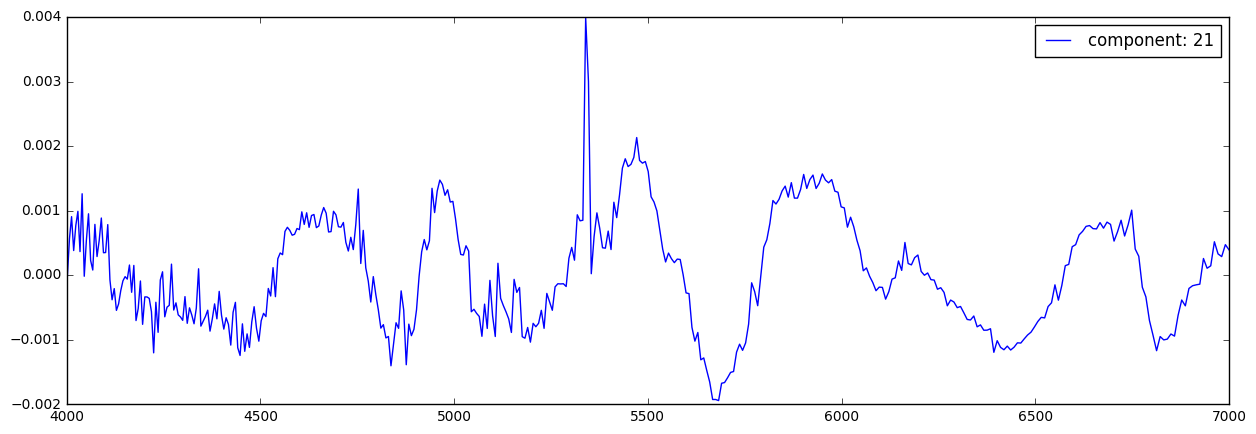

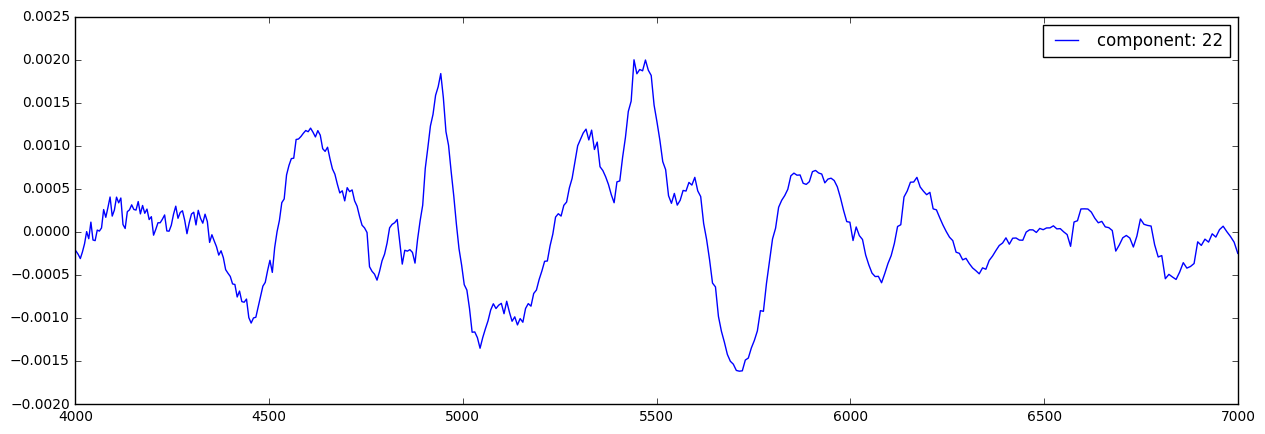

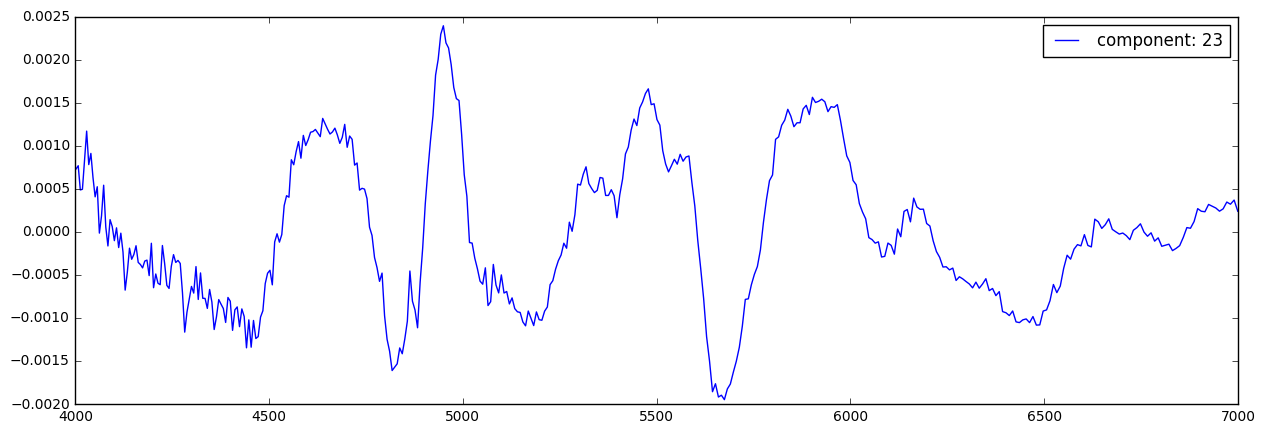

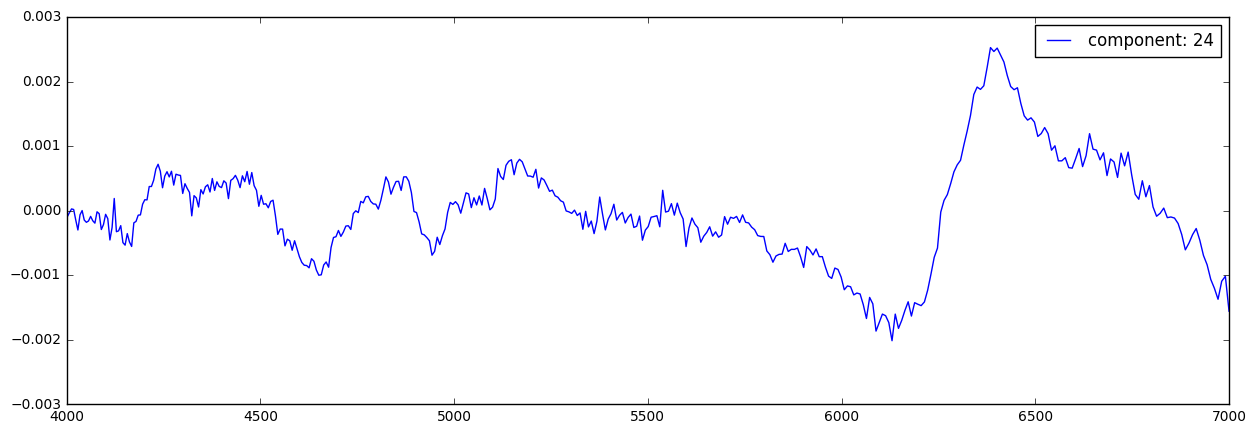

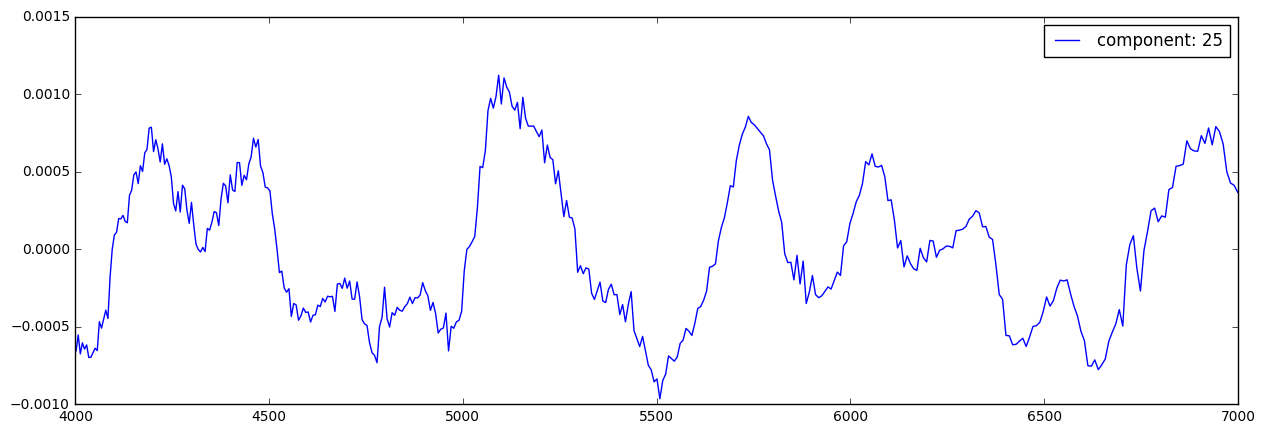

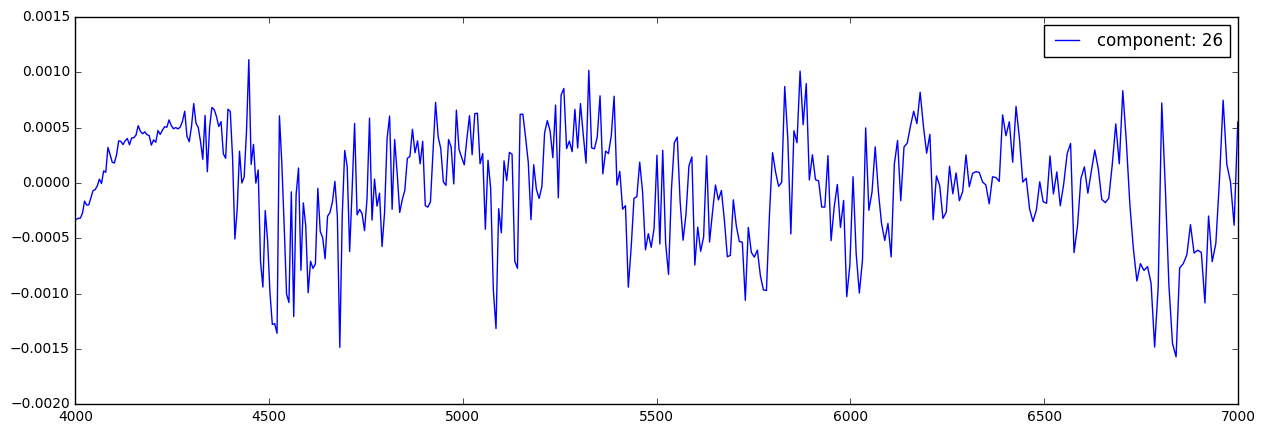

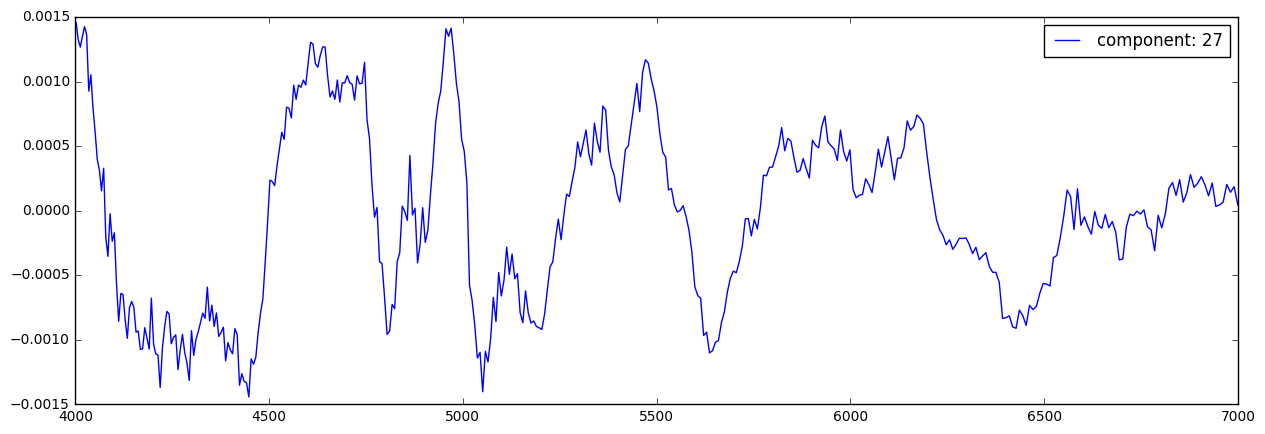

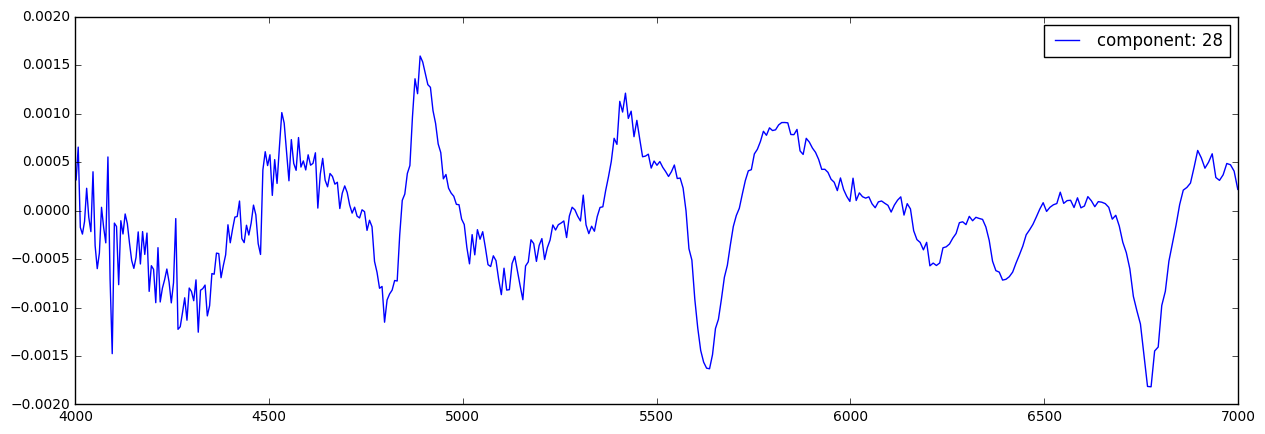

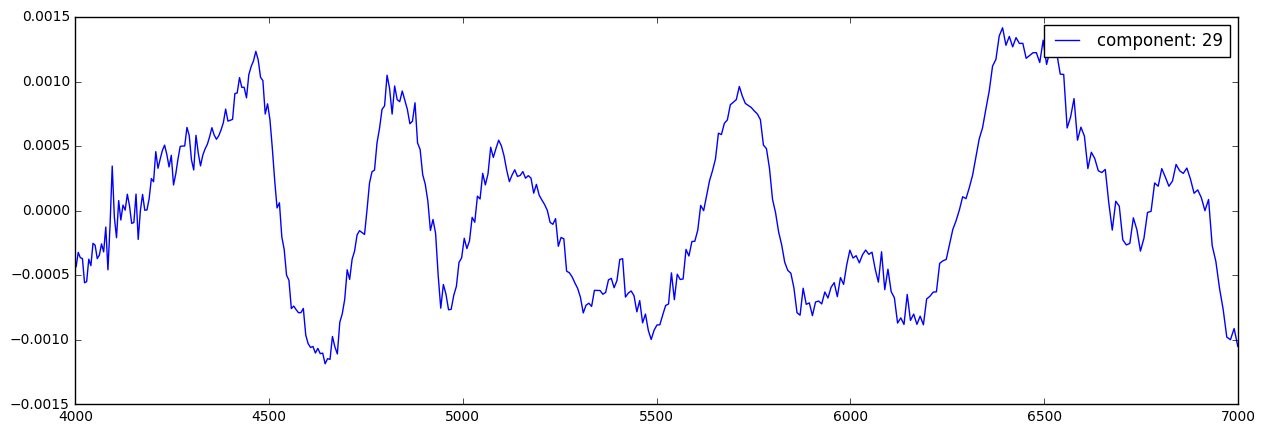

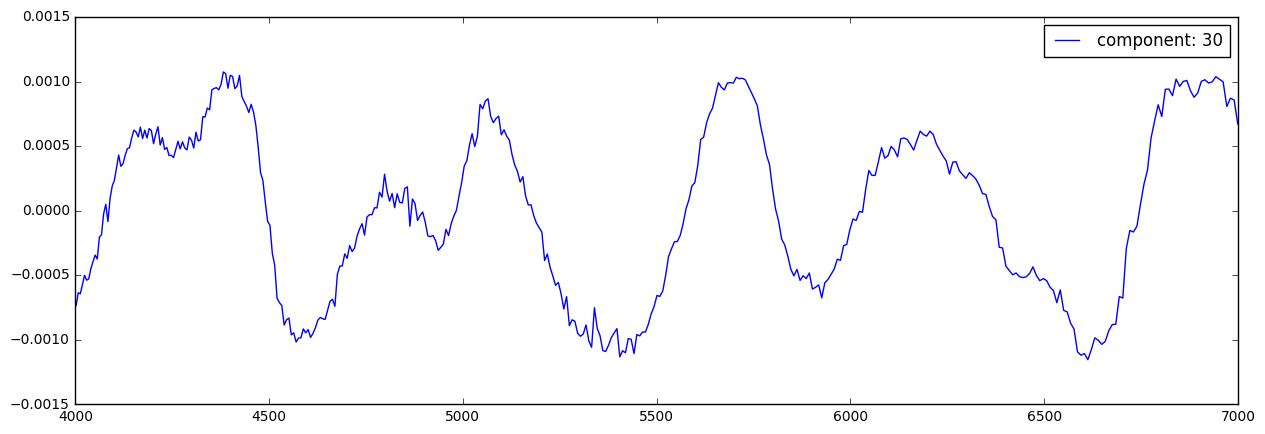

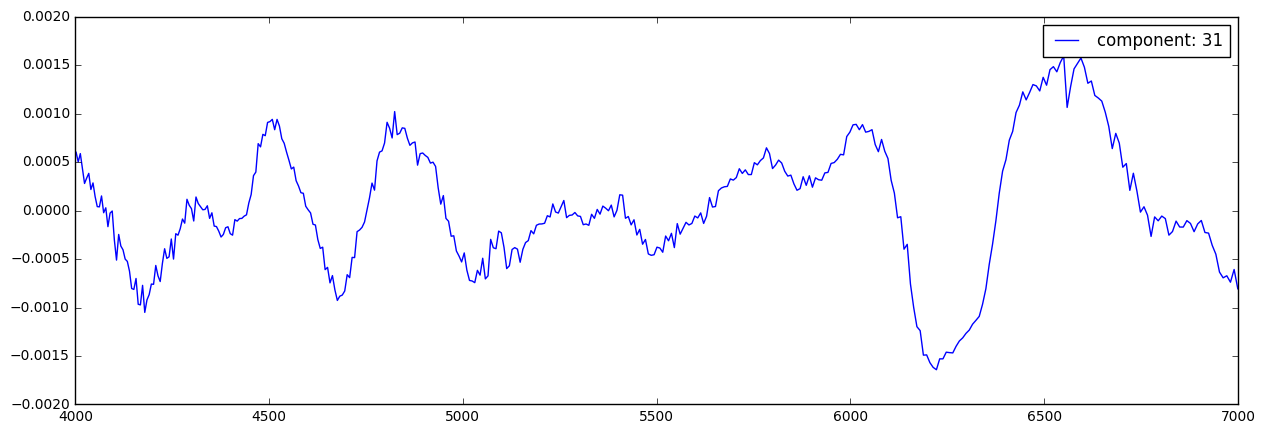

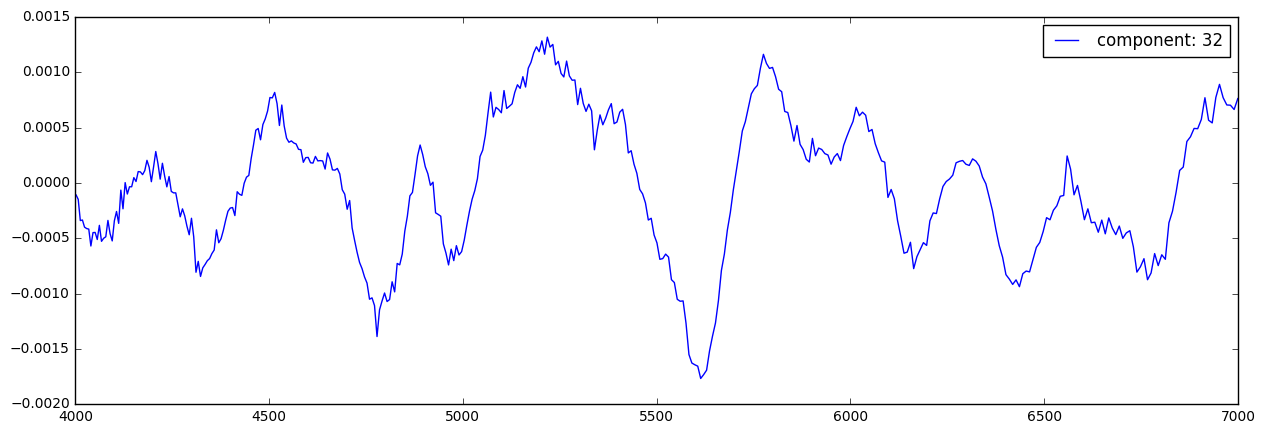

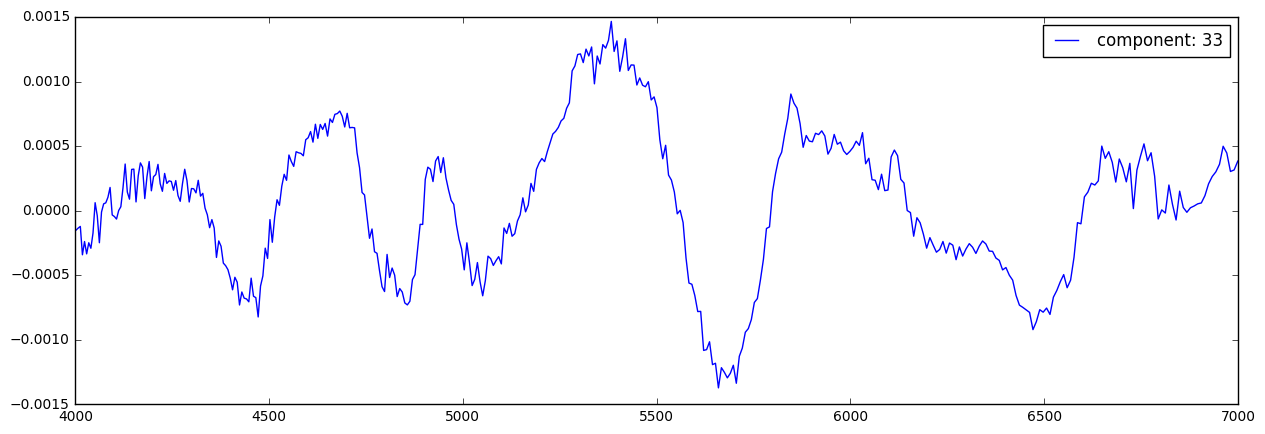

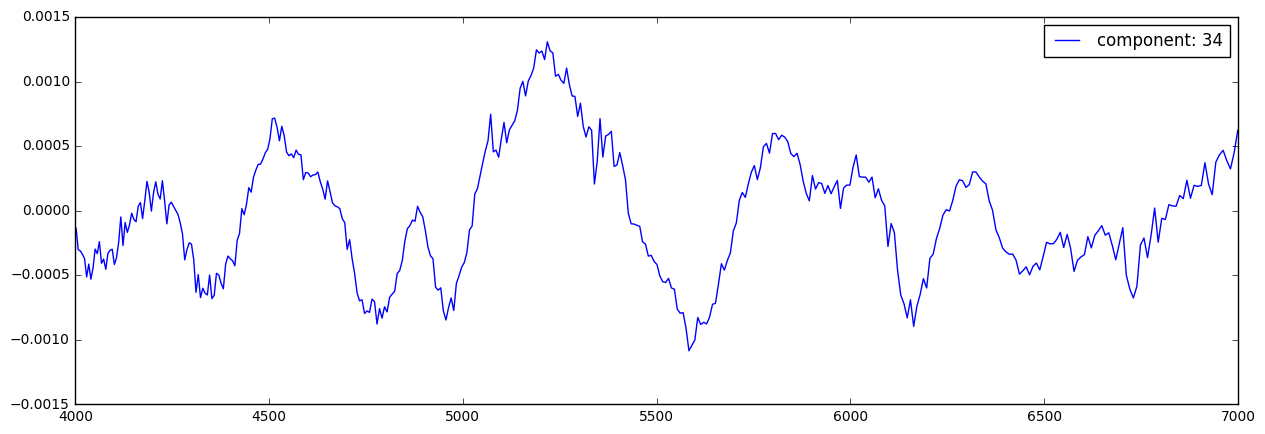

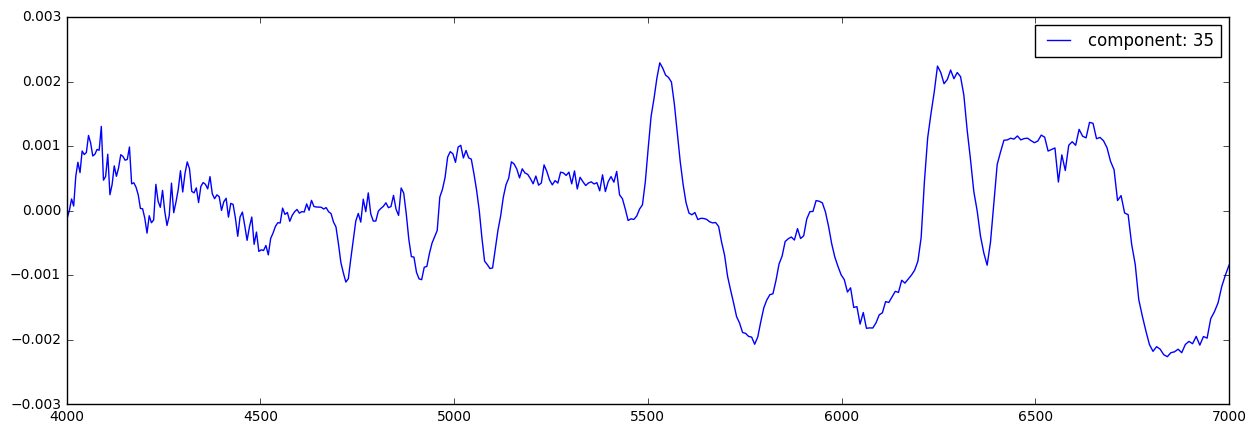

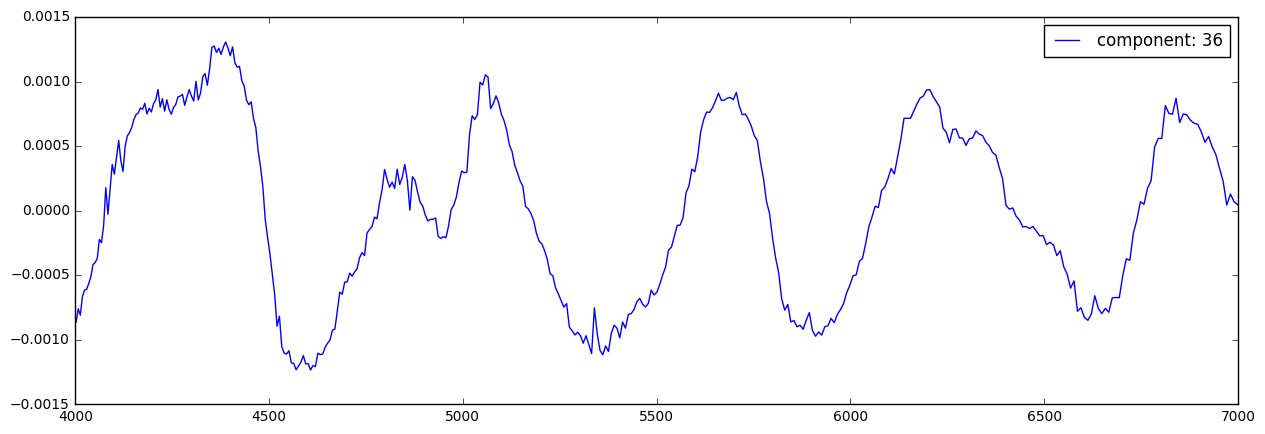

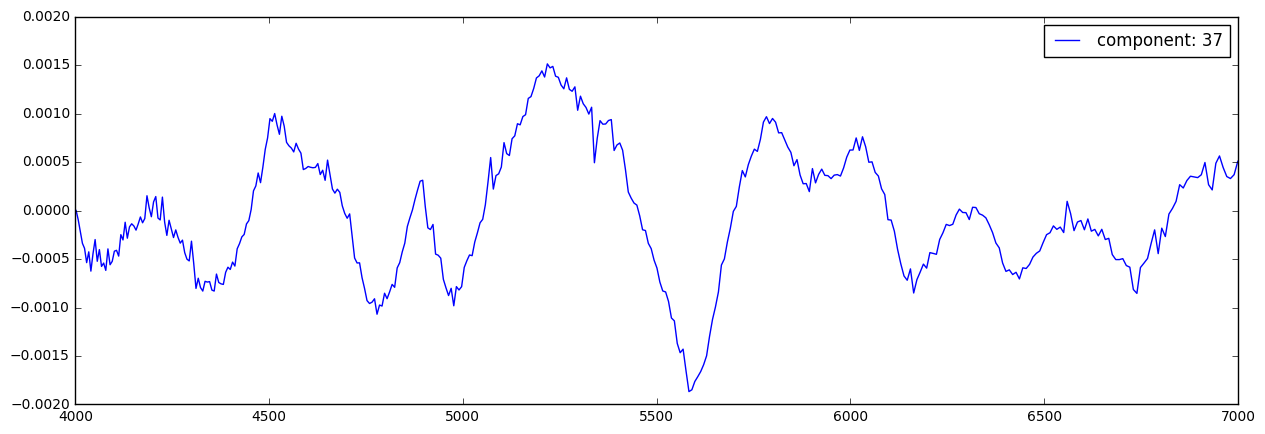

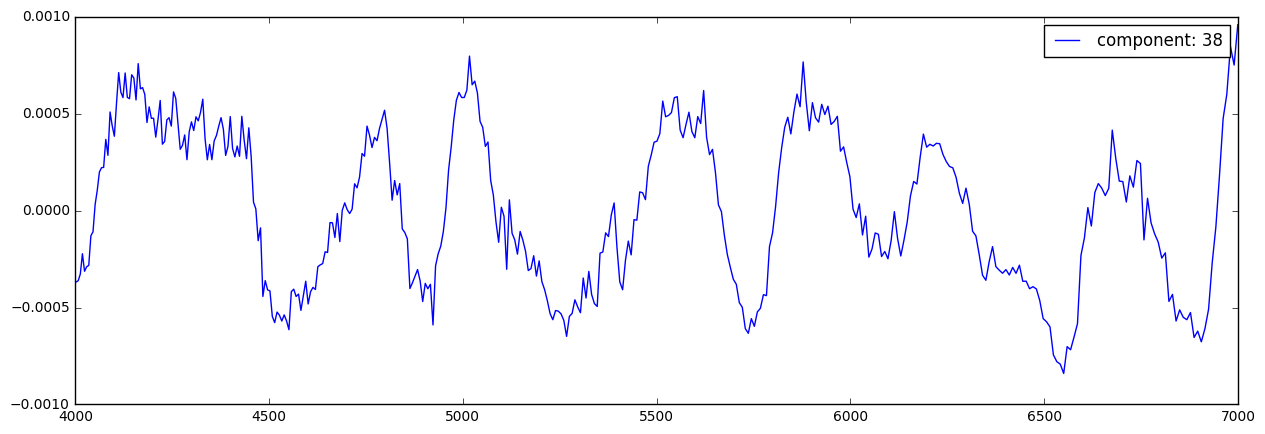

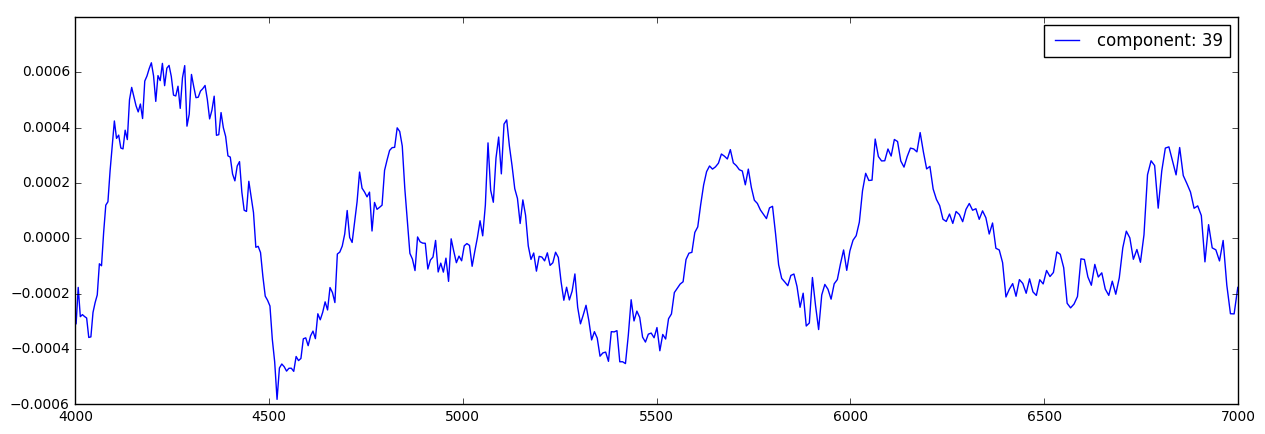

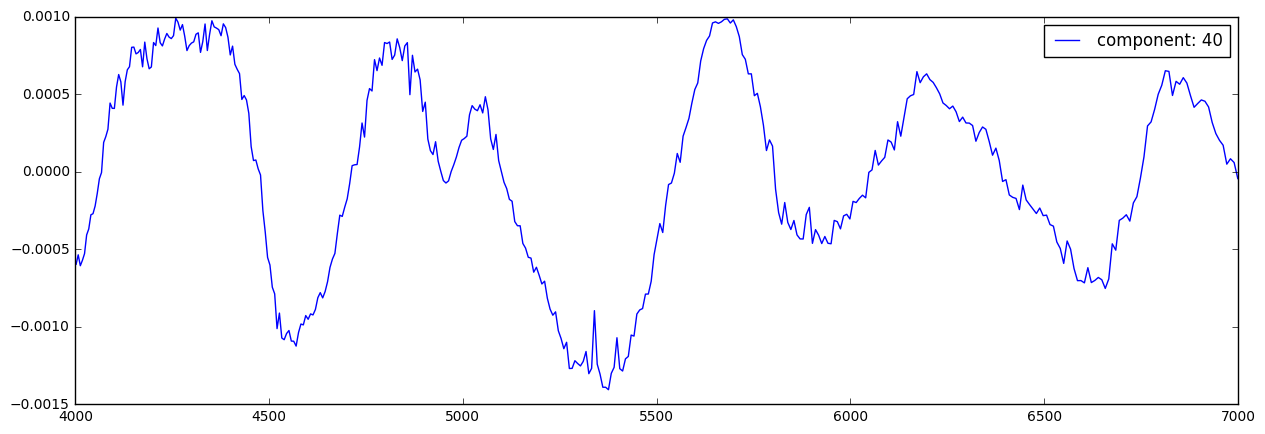

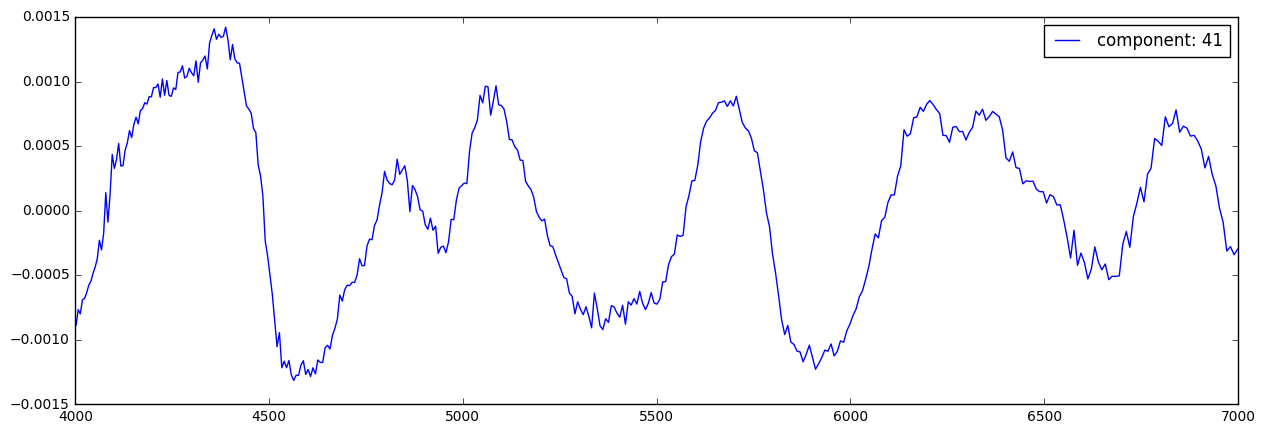

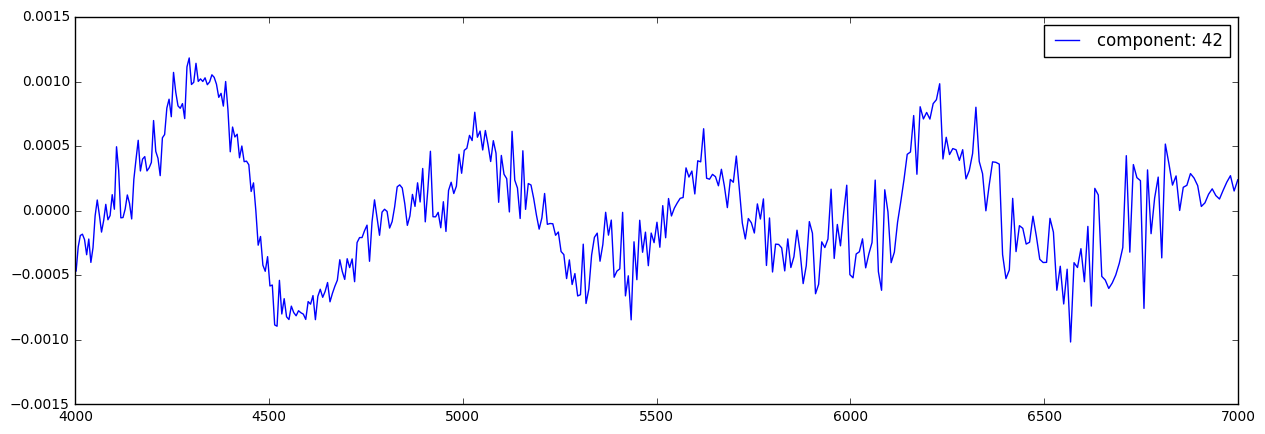

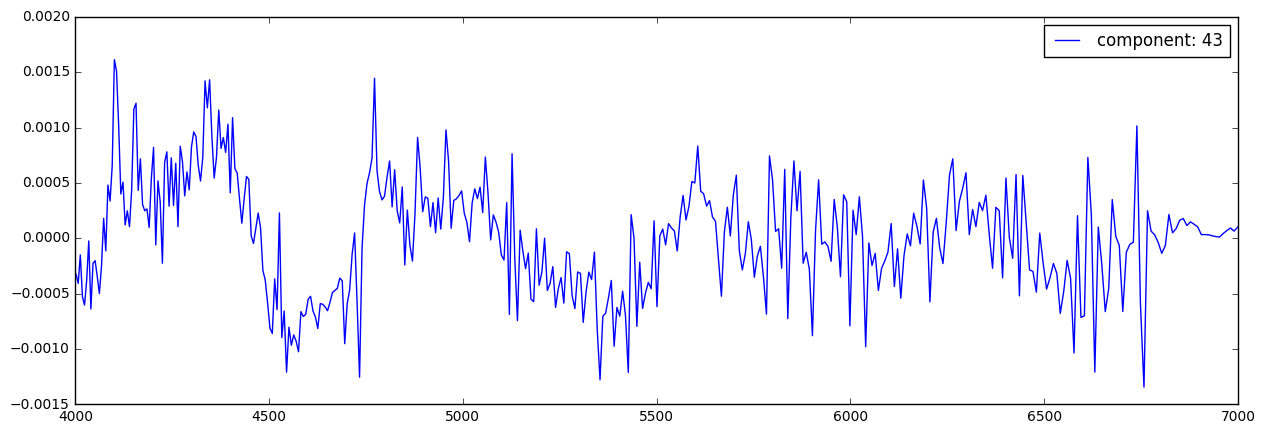

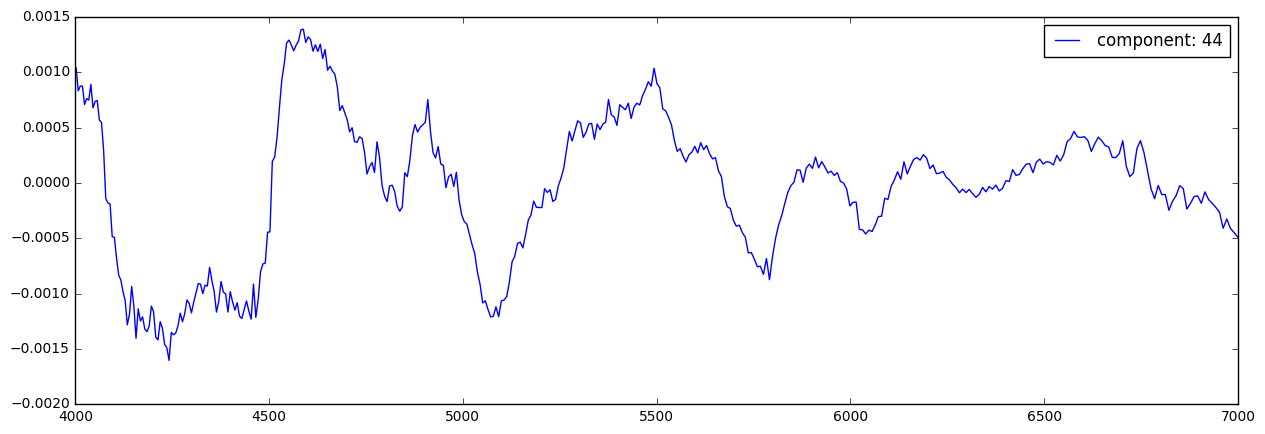

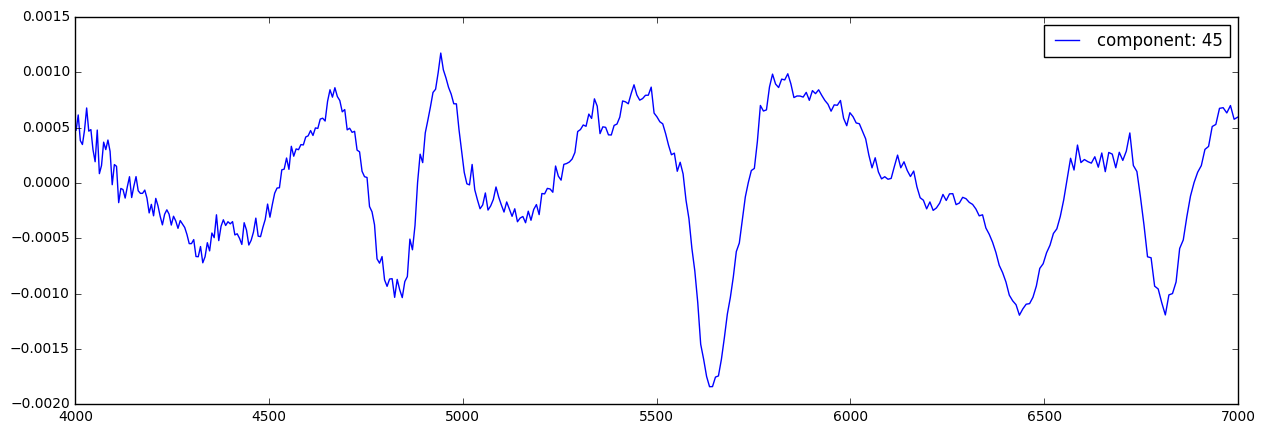

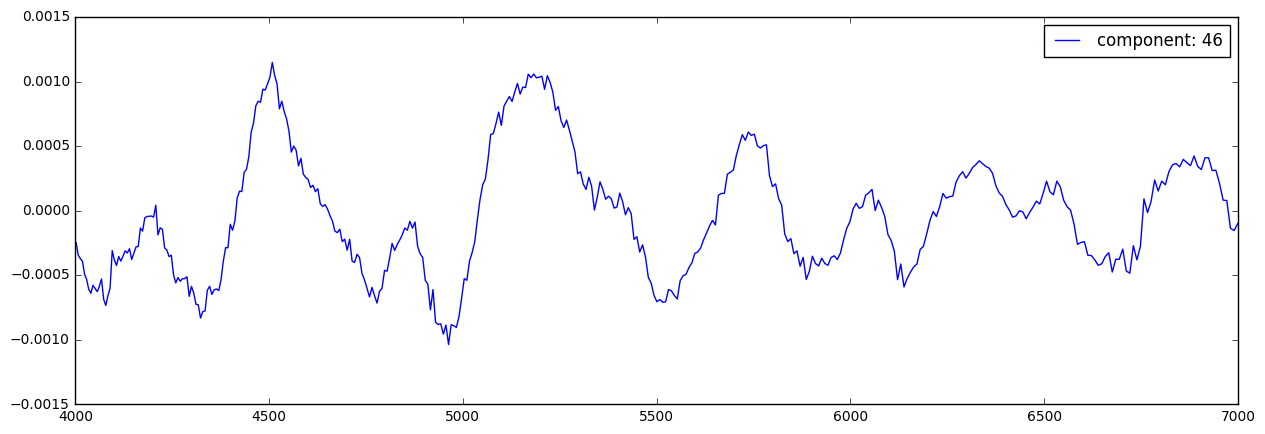

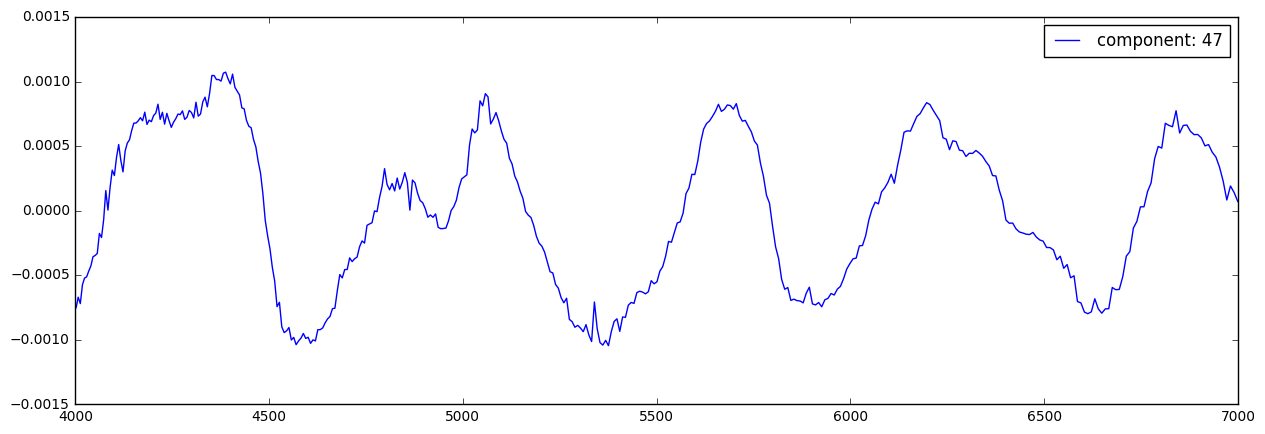

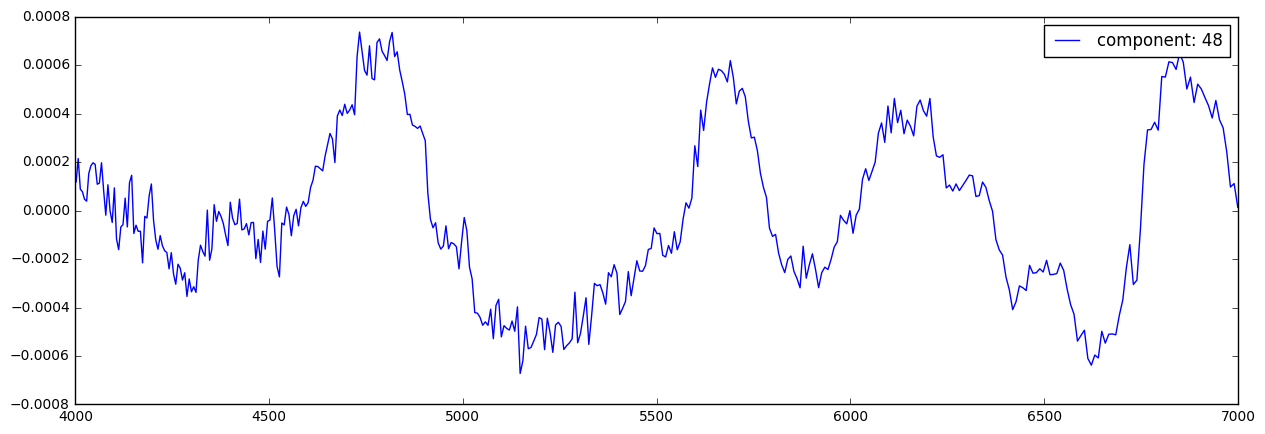

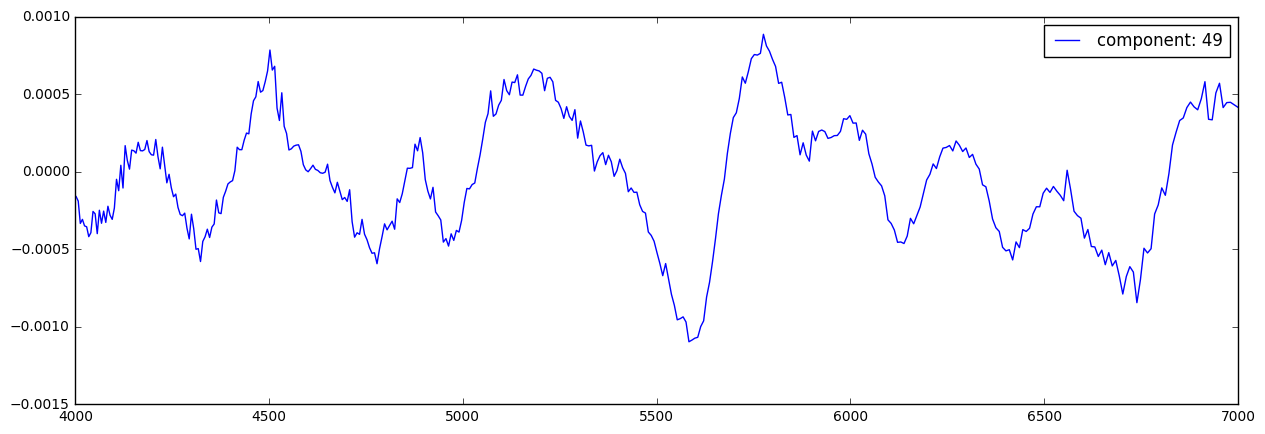

In [79]:
for i,kev in enumerate(k_back_evecs):
    plt.figure(figsize=(15,5))
    plt.plot(wavelengths,kevals[i]*(kev), label="component: %d"%i)
    plt.legend(fontsize=12)

In [54]:
spectra_pca_matrix.shape

(152, 46)

## Reconstruct Spectra using KPCA

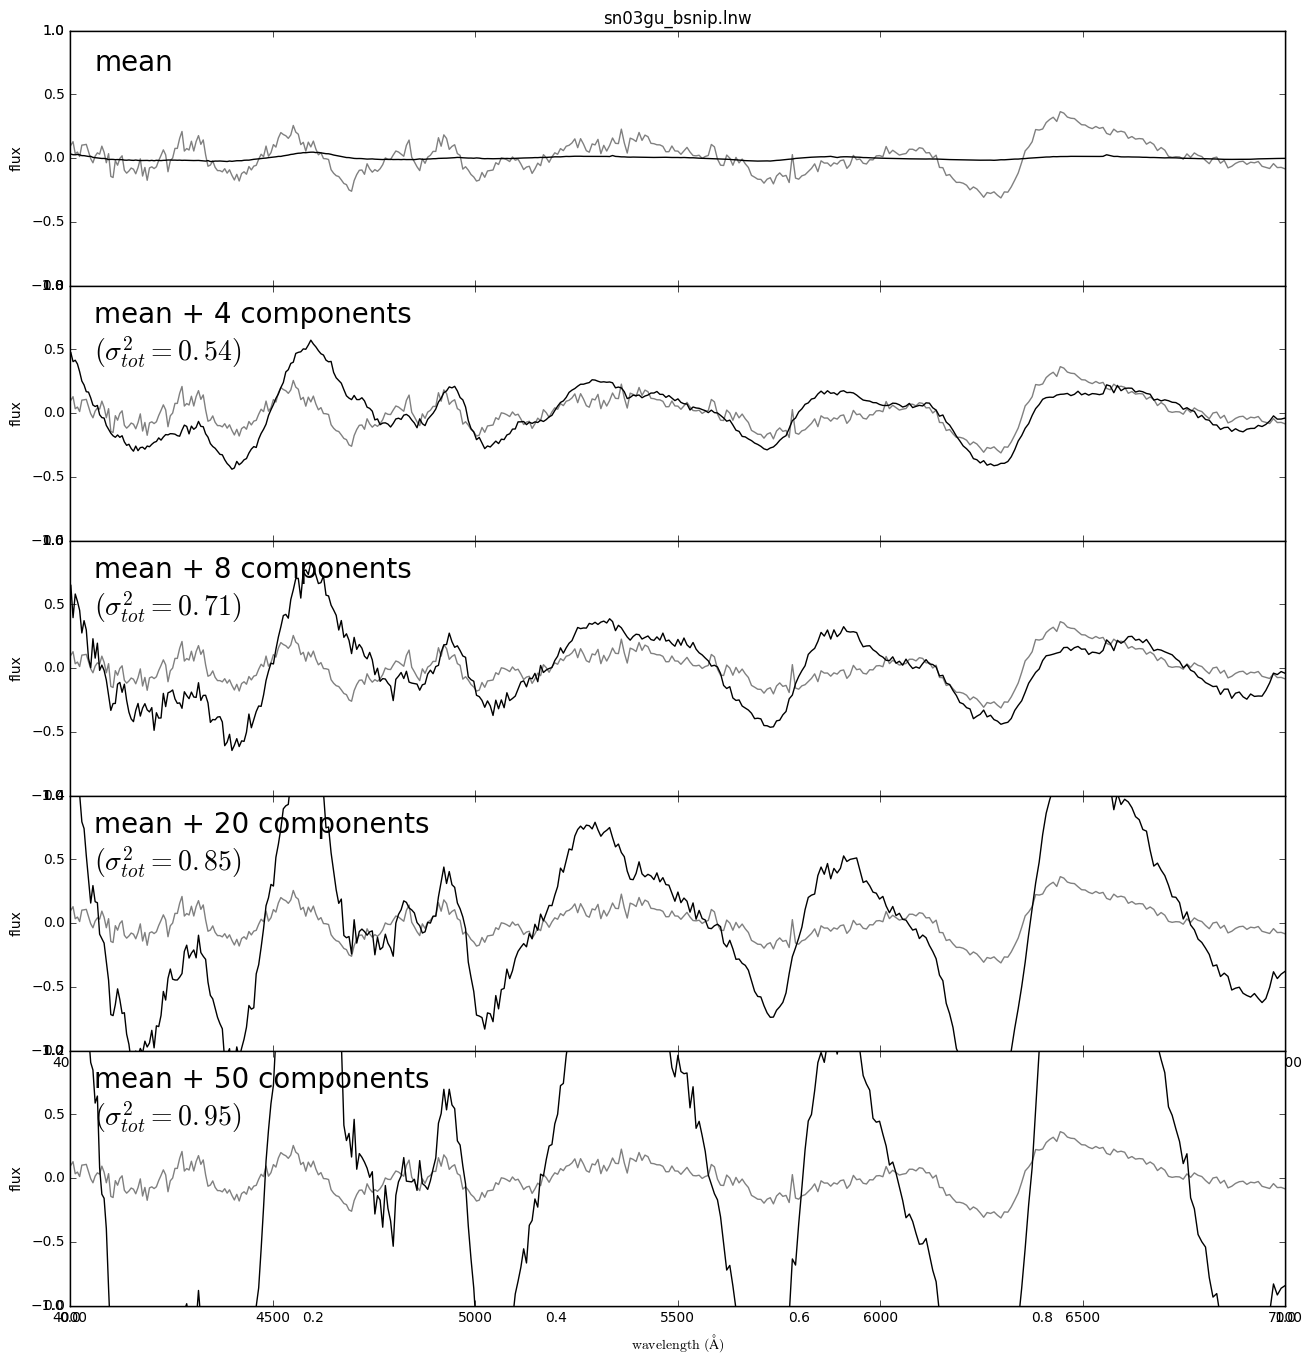

In [80]:
# Recreate 10 random spectra using the PCA decomposition
random_spec = np.random.randint(0,spectra_matrix.shape[0],1)
n_pca_components = [0,4,8,20,n_comp]

for j,spec in enumerate(random_spec):
    spec_name = Ib_Ic_names[spec]
    true_spec = (spectra_matrix[spec] + spectra_mean)*spectra_std
    
    pca_coeff = np.dot(k_back_evecs, spectra_matrix[spec])
    
    #------------------------------------------------------------
    # Plot the sequence of reconstructions
    fig = plt.figure(j, figsize=(15, 15))
    plt.title(spec_name)
    fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

    for i, n in enumerate(n_pca_components):#, len(pca.components_)]):
        ax = fig.add_subplot(511 + i)
        ax.plot(wavelengths, true_spec, '-', c='gray')
        ax.plot(wavelengths, (spectra_mean + np.dot(pca_coeff[:n], k_back_evecs[:n]))*spectra_std, '-k')
        
        if i < 3:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
            
        ax.set_ylim(-1, 1)
        ax.set_ylabel('flux')

        if n == 0:
            text = "mean"
        elif n == 1:
            text = "mean + 1 component\n"
            text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
        else:
            text = "mean + %i components\n" % n
            text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
            
        ax.text(0.02, 0.93, text, fontsize=20,ha='left', va='top', transform=ax.transAxes)

        fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')

In [122]:
a = 'sn2017ax.lnw'

In [125]:
a[:-4]

'sn2017ax'